In [1]:
import time
import os
import math
import datetime
import random
import collections
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from shapely.geometry import Point, Polygon, LineString

NOT_AVAILABLE_MSG = "No Available Trip in The Given Service Day"



In [2]:
trips_df = pd.read_csv("../../../data/mmt_gtfs/trips.csv")
routes_df = pd.read_csv("../../../data/mmt_gtfs/routes.csv")
stops_df = pd.read_csv("../../../data/bus_route_stop_info/stops.csv")
stops_df = stops_df[stops_df["Route"] != "None"]  # filter stops that are not currently in service
stop_times_df = pd.read_csv("../../../data/mmt_gtfs/stop_times.csv")
city = gpd.read_file("../../../data/plot/background/madison-shp")
water = gpd.read_file("../../../data/plot/background/water-shp")
street = gpd.read_file("../../../data/plot/background/streets-shp")
# zones = gpd.read_file("../../../data/plot/background/zoning_districts-shp")
# zones = zones.dropna(subset=["ZONING_COD"])  # filter districts without ZONING_COD data
wards = gpd.read_file("../../../data/population/wards-shp")
pop = pd.read_csv("../../../data/population/population.csv")
wards = wards[wards["WARD"].isin(pop["Ward"])]

In [85]:
s = pd.Series([3, 5, 7, 9], index=[2, 4, 6, 8])
# s.iloc[0]

In [86]:
# def generate_random(ward_file, pop_file, num_points=None, perc_pop=None):
#     """
#     Generate random points from the given ward_file (wards-shp) and pop_file (populaiton.csv).
#
#     Note:
#         One of num_points and perc_pop parameters should be None,
#         or both of them are None.
#         1. When both of them are None: 253,030 points will be generated.
#         2. num_points specified:       generate points >= 144 * num_points.
#         3. perc_pop   specified:       generate points >= 253,030 * (perc / 100)
#
#
#
#     Args:
#         ward_file:  shapely file with geometry data to generate points within each shape
#         pop_file:   population density file categorized by wards
#         num_points: number of points generated at each ward
#         perc_pop:   for example, perc_pop=50 is 50 percent of the population
#                     in that ward will be generated. perc_pop should be > 0, and < 100
#     Returns:
#          A dictionary of points (vals) categorized into 5 zoning districts (keys).
#     """
#     points_by_wards = {}
#
#     for idx, row in ward_file.iterrows():
#
#         # ward number
#         ward = row["WARD"]
#
#         if num_points != None:
#             # if number of points are given
#             pop = num_points
#         elif perc_pop != None:
#             pop = pop_file[pop_file["Ward"] == ward]["total"].iloc[0] * (perc_pop / 100)
#         else:
#             # population in that ward
#             pop  = pop_file[pop_file["Ward"] == ward]["total"].iloc[0]
#
#         # skip the ward where population is 0
#         # and avoid generating points in the same ward
#         if pop == 0 or ward in points_by_wards:
#             continue
#         else:
#             points_by_wards[ward] = []
#             shp_df = ward_file[ward_file["WARD"] == ward]
#
#             ############################################################
#             ############################################################
#             # example:
#             # ward 1 is split into 3 polygons in wards.shp-file
#             # suppose num_points is 10, we ceil(10 / 3) = 4
#             # so there will be 12 points generated in ward 1,
#             # each polygon will contain 4 points
#             ############################################################
#             ############################################################
#
#             # there'll be cases when a ward has more than one polygons
#             pop_for_each = math.ceil(pop / len(shp_df))
#             for i in range(len(shp_df)):
#                 poly = shp_df.iloc[i, -1]
#                 while len(points_by_wards[ward]) < pop_for_each * (i + 1):
#                     minx, miny, maxx, maxy = poly.bounds
#                     pnt = Point(random.uniform(minx, maxx),
#                                 random.uniform(miny, maxy))
#                     if poly.contains(pnt):
#                         points_by_wards[ward].append(pnt)
#     return points_by_wards
#
# pts = generate_random(wards, pop, perc_pop=1)

In [171]:
# service type
serv_types = {
    "wkd": ["93_WKD", "93_WKD:L#6", "93_WKD:L=6", "93_WKD:R",
            "93_WKD:S", "93_WKD:S#6", "93_WKD:S=6"],
    "sat": ["93_SAT", "93_SAT:L", "93_SAT:R", "93_SAT:S"],
    "sun": ["93_SUN", "93_SUN:L", "93_SUN:R", "93_SUN:S"],
    "hol": ["93_D24", "93_D31", "93_HOL", "93_HOL:R"],
    "mwk": ["93_MWK", "93_MWK:R"]}


def generate_random(ward_file, pop_file, num_points=None, perc_pop=None):
    """
    Generate random points from the given ward_file (wards-shp) and pop_file (populaiton.csv).
    Note:
        One of num_points and perc_pop parameters should be None,
        or both of them are None.
        1. When both of them are None: 253,030 points will be generated.
        2. num_points specified:       generate points >= 144 * num_points.
        3. perc_pop   specified:       generate points >= 253,030 * (perc / 100)
    Args:
        ward_file:  shapely file with geometry data to generate points within each shape
        pop_file:   population density file categorized by wards
        num_points: number of points generated at each ward
        perc_pop:   for example, perc_pop=50 is 50 percent of the population
                    in that ward will be generated. perc_pop should be > 0, and < 100
    Returns:
        A dictionary of points (vals) categorized into 5 zoning districts (keys).
    """
    points_by_wards = {}

    for idx, row in ward_file.iterrows():

        # ward number
        ward = row["WARD"]

        if num_points != None:
            pop = num_points
        elif perc_pop != None:
            pop = pop_file[pop_file["Ward"].isin([ward])]["total"].iloc[0] * perc_pop * 0.01
        else:
            pop  = pop_file[pop_file["Ward"].isin([ward])]["total"].iloc[0]

        # skip the ward where population is 0
        # and avoid generating points in the same ward
        if pop == 0 or ward in points_by_wards:
            continue
        else:
            points_by_wards[ward] = []
            shp_df = ward_file[ward_file["WARD"].isin([ward])]

            ############################################################
            ############################################################
            # example:
            # ward 1 is split into 3 polygons in wards.shp-file
            # suppose num_points is 10, we ceil(10 / 3) = 4
            # so there will be 12 points generated in ward 1,
            # each polygon will contain 4 points
            ############################################################
            ############################################################

            # there'll be cases when a ward has more than one polygons
            pop_for_each = math.ceil(pop / len(shp_df))
            for i in range(len(shp_df)):
                poly = shp_df.iloc[i, -1]
                while len(points_by_wards[ward]) < pop_for_each * (i + 1):

                    minx, miny, maxx, maxy = poly.bounds
                    pnt = Point(random.uniform(minx, maxx),
                                random.uniform(miny, maxy))
                    if poly.contains(pnt):
                        points_by_wards[ward].append(pnt)

    return dict(collections.OrderedDict(sorted(points_by_wards.items())))

def plot_random(random_points, ax, **kwargs):
    """
    Generate a geo-plot using points generated by the generate_random() method.

    Args:
         random_points: points returned by generate_random() method
         ax:            ax to plot the geo map
         **kwargs:      setting of the geo map
    Returns:
        A dictionary of points (vals) categorized into area of wards (keys).
    """

    handles = []
    points = random_points  # points_by_zone
    for key, pts in points.items():
        x = []
        y = []
        for pt in pts:
            x.append(float(pt.x))
            y.append(float(pt.y))
        plt.scatter(x, y, c="k", **kwargs)

    return points

# source: https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def find_near_stops(points, stops_df, threshold=400):
    """
    Find the nearest bus stops for each point in the points parameter.

    Args:
        points:    a list of shapely Point objects
        stops_df:
        threshold: find number of bus stops within the distance threshold (in meters)
                   by default is 400 meters (or 1/4 miles). e.g. number of bus stops
                   within 400 meters from one generated point.
    Returns:
        a DataFrame of columns: districts, stop_id, stop_lat, stop_lon,
                                pt_lon, pt_lat, distance (in meters),
                                num_available_stops, num_available_routes, ids_dist
    """
    ids =        []  # store the stop id of the nearest bus stop
    dists =      []  # store the shortest distance to the nearest bus stop
    stop_lons =  []  # longitude of the stop id
    stop_lats =  []  # latitude of the stop id
    pt_lons =    []  # longitude of the generated pt
    pt_lats =    []  # latitude of the generated pt
    wards =  []  # district name where the pt is generated
    num_stops =  []  # number of available bus stops within the distance threshold (None if the nearest one > threshold)
    routes =     []  # available routes within the distance threshold (None if the nearest one > threshold)
    num_routes = []  # number of avaialable routes within the distance threshold (None if the nearest one > threshold)
    ids_dist =   []  # list of tuples of (stop_ids, distances) to the bus stop (None if the nearest one > threshold)

    for key, pts in points.items():
        for pt in pts:
            xs = [pt.x] * len(stops_df)
            ys = [pt.y] * len(stops_df)

             # element wise operation to calculate distances
            kms = haversine_np(xs, ys, stops_df["stop_lon"], stops_df["stop_lat"])

            idx = kms.idxmin()  # index of the smallest value
            stop_id = stops_df.loc[idx, "stop_id"]
            lon = stops_df.loc[idx, "stop_lon"]
            lat = stops_df.loc[idx, "stop_lat"]
            dist = round(kms.loc[idx] * 1000, 2)  # convert km to meters

            ids.append(stop_id)
            stop_lons.append(lon)
            stop_lats.append(lat)
            pt_lons.append(pt.x)
            pt_lats.append(pt.y)
            dists.append(dist)
            wards.append(key)

            # calculate number of available bus stops and routes
            # within the threshold distance

            ####################################################################
            ##################    Optimization approach    #####################
            ####################################################################
            #
            # ms = kms * 1000
            # fitered_ms = ms[ms <= threshold]
            # sorted_filtered_ms = fitered_ms.sort_values(ascending=True)
            # num_stops_cnt = len(sorted_filtered_ms)
            # num_routes_cnt = stops_df[stops_df.index.isin([sorted_filtered_ms.index])]["Route"].str.split(",")
            # ids_dist_tuple = list(pd.DataFrame(
            #                             {
            #                                 'stop_id': stops_df[stops_df["stop_id"].isin([sorted_filtered_ms.index])]["stop_id"],
            #                                 'dist': np.round(sorted_filtered_ms.values, 2)
            #                             }).to_records(index=False))
            ####################################################################
            ####################################################################
            ####################################################################

            sorted_km = kms.sort_values(ascending=True)
            num_stops_cnt  = 0
            num_routes_cnt = []
            ids_dist_tuple = []
            for idx, val in sorted_km.items():
                dist = round(val * 1000, 2)
                if dist <= threshold:
                    num_stops_cnt += 1
                    ids_dist_tuple.append((stops_df.loc[idx, "stop_id"], dist))
                    num_routes_cnt.extend(stops_df.loc[idx, "Route"].split(", "))
                else:
                    break

            num_stops.append(num_stops_cnt)
            routes.append(sorted(map(int, list(set(num_routes_cnt)))))
            num_routes.append(len(list(set(num_routes_cnt))))
            ids_dist.append(ids_dist_tuple)

    stops = pd.DataFrame({
        "wards": wards,
        "pt_lon": pt_lons,
        "pt_lat": pt_lats,
        "stop_id (nearest)": ids,
        "stop_lon (nearest)": stop_lons,
        "stop_lat (nearest)": stop_lats,
        "distance (nearest, in meters)": dists,
        "num_available_stops (within {}m)".format(threshold): num_stops,
        "num_available_routes (within {}m)".format(threshold): num_routes,
        "available_routes (within {}m)".format(threshold): routes,
        "ids_dist": ids_dist
    })
    return stops

def connect_to_stops(ax, stops):
    """
    Draw a line from randomly generated points to nearest bus stops that are in service.

    Args:
        ax: ax to draw lines
        stops: stops dataframe returned by find_near_stop() method
    Returns:
        None
    """
    linestrings = []
    for idx, row in stops.iterrows():
        ls = LineString([(row["pt_lon"], row["pt_lat"]),
                         (row["stop_lon (nearest)"], row["stop_lat (nearest)"])])
        linestrings.append(ls)

    df = pd.DataFrame({"geometry":linestrings})
    df.set_geometry("geometry").plot(ax=ax, color="k", linestyle="--", alpha=0.5)


def minute_wait(stops, t, serv, trips_df, stop_times_df):
    """
    Find the soonest coming bus and calculate the expected waiting times,
    given the time and service type

    Args:
        stops: stops dataframe returned by the find_near_stops columns
        t:     time, datatime object
        serv:  service type (wkd, sat, sun, hol, mwk)
    Returns:

    """
    # filtered trips by service type
    trips_by_serv = trips_df[trips_df["service_id"].isin(serv_types[serv])]

    min_waits = []     # list of minimum waiting time
    chosen_trip_ids = []  # list of minimum waiting time trip_id
    chosen_stop_ids = []  # list of chosen stop_id


    for idx, row in stops.iterrows():

        # if there are many bus stops within the threshold distance,
        # we want to find the soonest coming bus from all near bus stops
        # else use the nearest if no bus stops nearby
        stop_ids = []
        if len(row["ids_dist"]) == 0:
            stop_ids = [row["stop_id (nearest)"]]
        else:
            stop_ids = [tup[0] for tup in row["ids_dist"]]


        # filter stop_id by service type
        matched_stops = stop_times_df[stop_times_df["stop_id"].isin(stop_ids)]
        filtered_trips = trips_by_serv[trips_by_serv["trip_id"].isin(matched_stops["trip_id"])]
        matched = matched_stops[matched_stops["trip_id"].isin(filtered_trips["trip_id"])]

        # find waiting time for the soonest coming route and trip_id of that route
        schedules = pd.to_timedelta(matched["arrival_time"])


        if len(schedules) != 0:
            times = pd.Series([datetime.timedelta(hours=t.hour,
                                                  minutes=t.minute,
                                                  seconds=t.second)] * len(schedules), index=schedules.index)
            diff = schedules - times
            sorted_diff_sec = diff.sort_values().dt.total_seconds()
            diff_sec = sorted_diff_sec[sorted_diff_sec > 0]


            if len(diff_sec) == 0:
                #############################################################################
                ##########   there're routes that only run at a certain time   ##############
                ##########   e.g. in the morning                               ##############
                #############################################################################
                min_waits.append(None)
                chosen_trip_ids.append(None)
                chosen_stop_ids.append(None)
            else:
                min_waits.append(diff_sec.iloc[0] / 60)
                chosen_trip_ids.append(matched.loc[diff_sec.index[0]]["trip_id"])
                chosen_stop_ids.append(matched.loc[diff_sec.index[0]]["stop_id"])
        else:
            min_waits.append(None)
            chosen_trip_ids.append(None)
            chosen_stop_ids.append(None)

    stops["minutes_wait"] = min_waits
    stops["trip_id (chosen)"] = chosen_trip_ids
    stops["stop_id (chosen)"] = chosen_stop_ids

    # find the route that's coming by trip_id
    route_coming = []
    for idx, row in stops.iterrows():
        trip_id = row["trip_id (chosen)"]
        if np.isnan(trip_id):
            route_coming.append(NOT_AVAILABLE_MSG)
        else:
            route_coming.append(trips_df[trips_df["trip_id"].isin([trip_id])]["route_short_name"].iloc[0])
    stops["coming_route"] = route_coming

    return stops


def get_service_type(serv):
    """convert service_type for the use of plot title"""
    if serv == "wkd":
        return "Weekday"
    if serv == "sat" or "sun":
        return "Weekend"
    if serv == "hol":
        return "Holiday"
    else:
        return "Modified_Week"

def get_full_time(t):
    """convert time object for the use of plot title"""
    return " at " + str(t.hour) + ":" + str(t.minute) + ":" + str(t.second)

def generate_sim(t, serv,
                 wards_df, pops_df, stops_df, stop_times_df, trips_df,
                 num_points=None, perc_pop=None, coords=None, threshold=400):
    """
    Randomly generates points in Madison and calculates nearest stop_id, lon/lat, distance
    from each point, and calculates the number of available stops/routes within the given
    threshold distance, and estimates the minimum waiting time from all avaialable stops within the
    given threshold distance.

    Args:
        t:
        serv:
        wards_df:
        pops_df:
        stops_df:
        stop_times_df:
        trips_df:
        num_points: see docstring of generate_randome() method
        perc_pop:   see docstring of generate_randome() method
        coords:     a dictionary with key = wards, val = list of points
                    if not given, randomly generate points using generate_random() method
        threshold:
        geo_plot:
    Return:
        A dataframe of simulated data and a randomly generated points for the use of
        generating a set of simulations of different times and service types.
    """
    points = 0
    if coords == None:
        points = generate_random(wards_df, pops_df, num_points, perc_pop)
        # print("generate random points " + str(round((end - start) * 1000, 2)) + "ms")
    else:
        points = coords

    start = time.time()
    stops = find_near_stops(points, stops_df, threshold)
    end = time.time()
    # print("find near stops " + str(round((end - start) * 1000, 2)) + "ms")

    start = time.time()
    stops = minute_wait(stops, t, serv, trips_df, stop_times_df)
    end = time.time()
    # print("find waiting time " + str(round((end - start) * 1000, 2)) + "ms")



    return points, stops

t = datetime.time(12, 00, 00)
serv = "wkd"
start = time.time()
points, wkd = generate_sim(t, serv, wards, pop,
                           stops_df, stop_times_df, trips_df,
                           perc_pop=0.05, geo_plot=True)

# 30 percent of the population takes about 15 mins
# generating 75949 riders

end = time.time()
print("total execution time " + str(round((end - start) * 1000, 2)) + "ms")

total execution time 3248.62ms


In [172]:
wkd.head(2)

wards     pt_lon     pt_lat  stop_id (nearest)  stop_lon (nearest)  \
0      1 -89.271418  43.042974               3243          -89.286618   
1      1 -89.286166  43.021338               3311          -89.289833   

   stop_lat (nearest)  distance (nearest, in meters)  \
0           43.043097                        1234.53   
1           43.026762                         672.35   

   num_available_stops (within 400m)  num_available_routes (within 400m)  \
0                                  0                                   0   
1                                  0                                   0   

  available_routes (within 400m) ids_dist  minutes_wait  trip_id (chosen)  \
0                             []       []     45.666667         1023132.0   
1                             []       []     39.800000         1023132.0   

   stop_id (chosen) coming_route  
0            3243.0           31  
1            3311.0           31

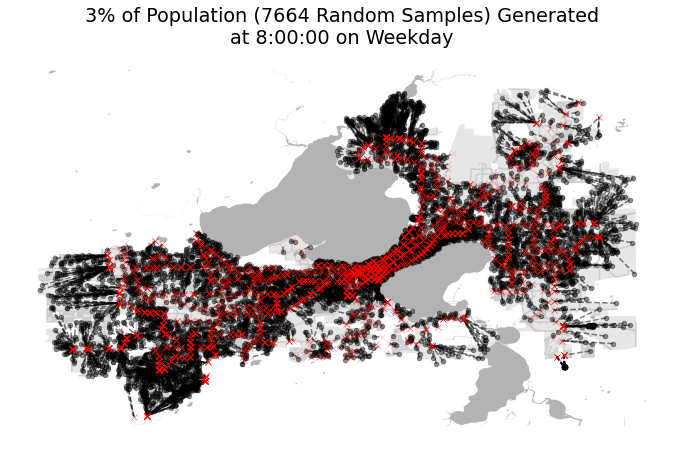

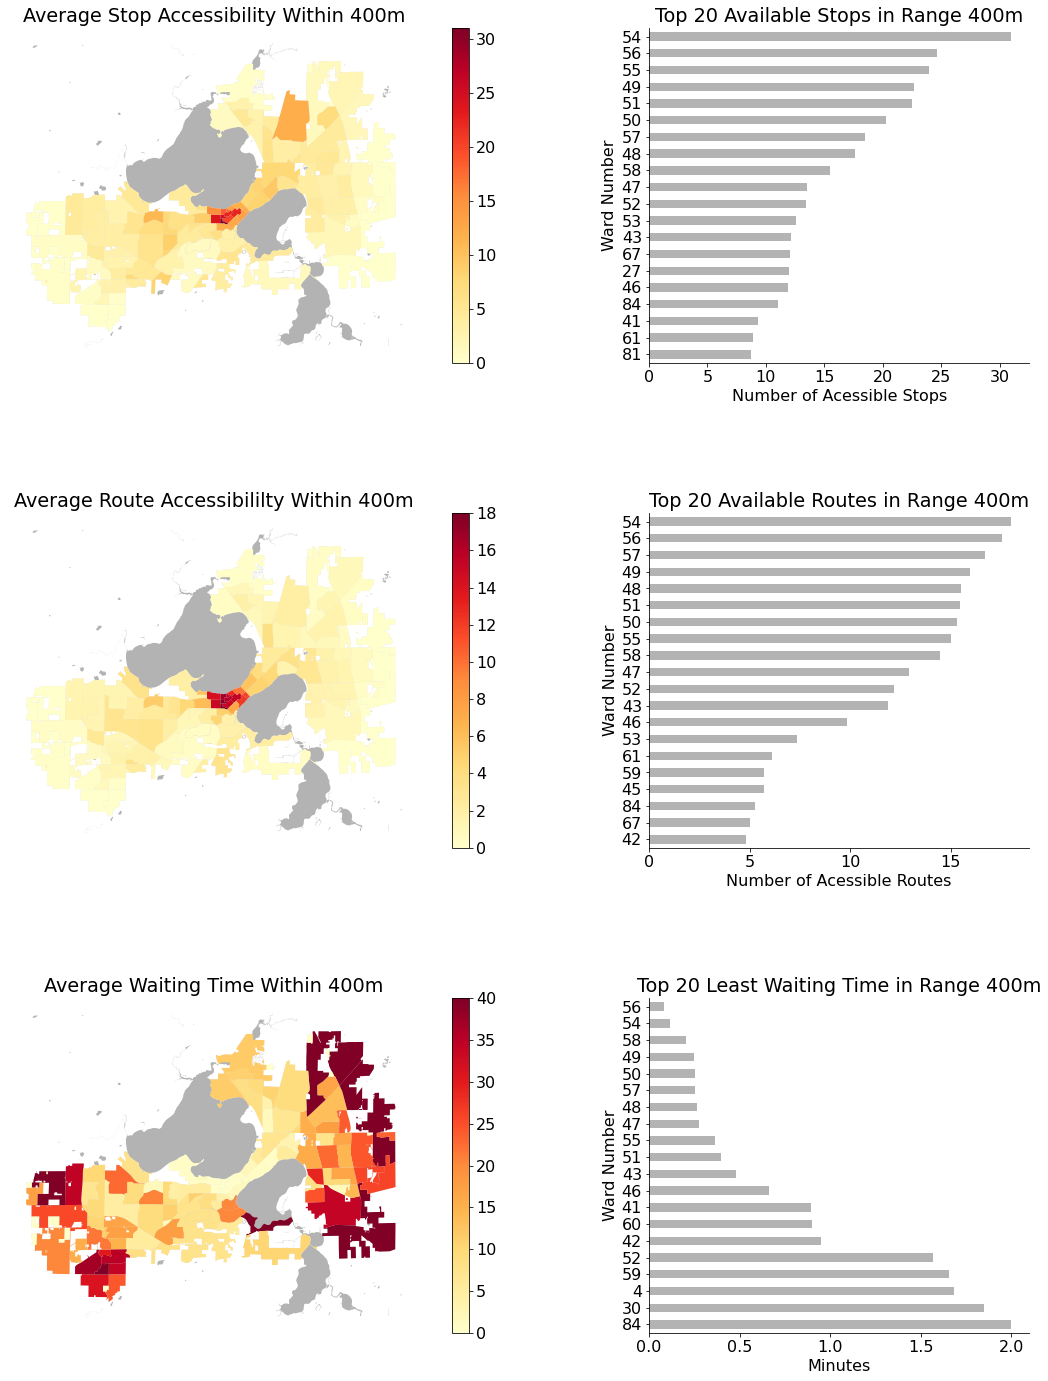

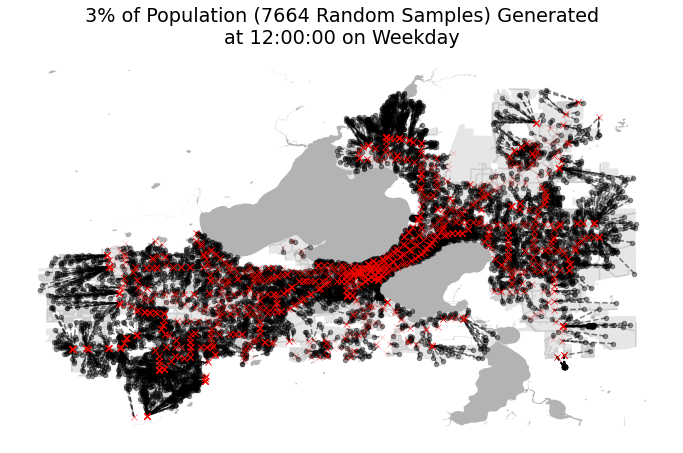

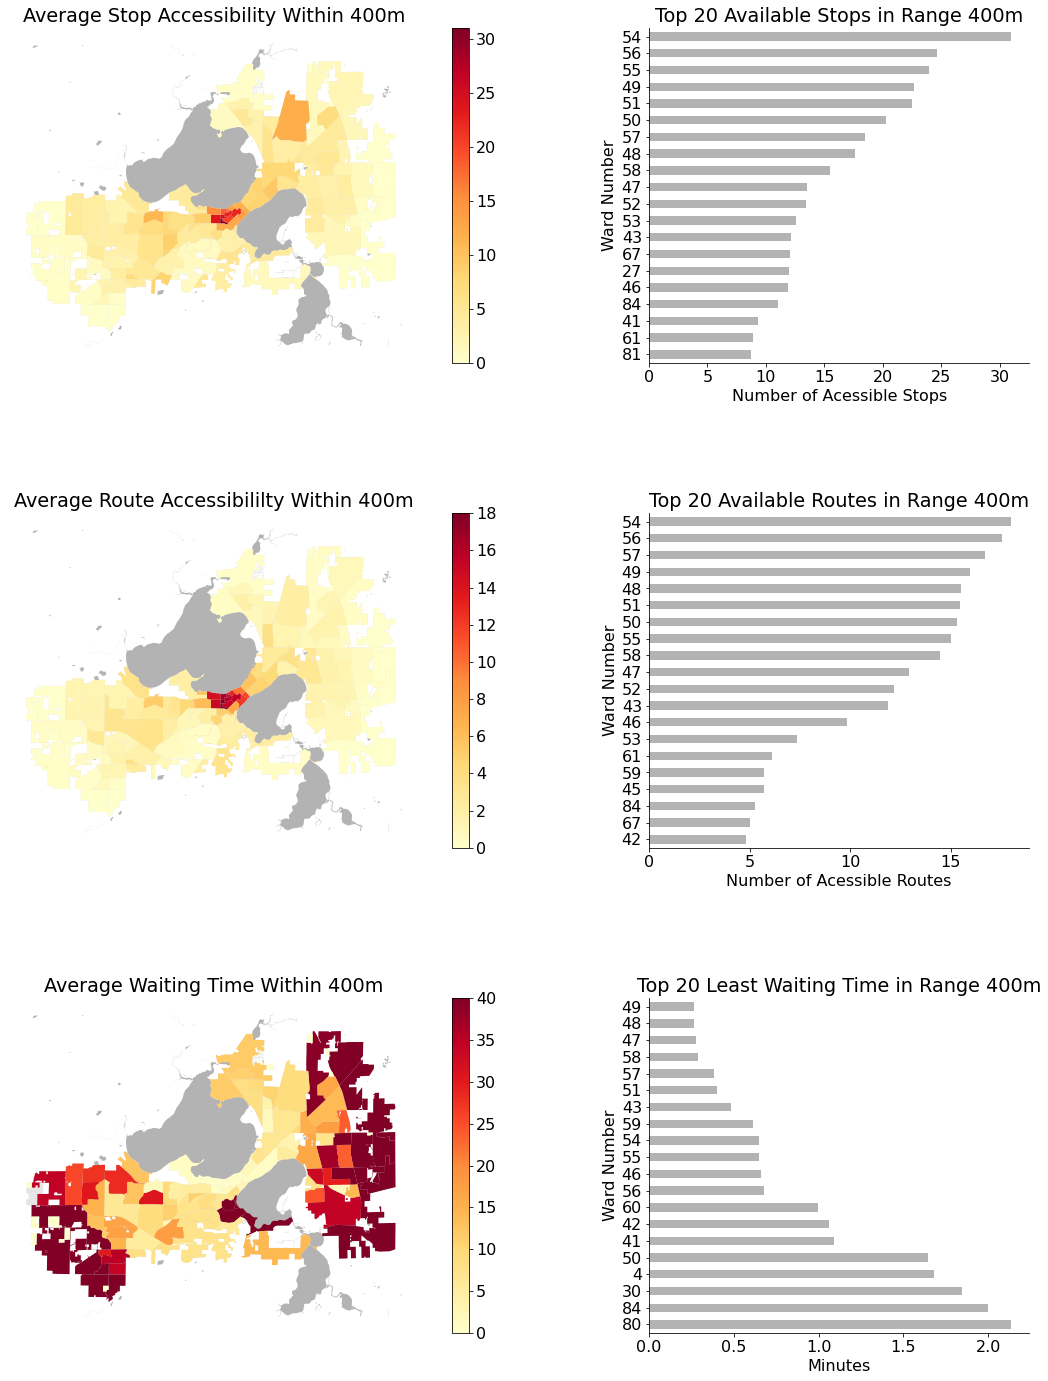

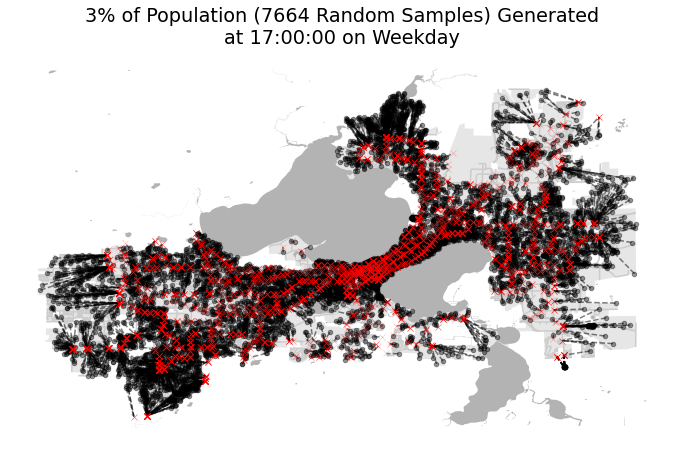

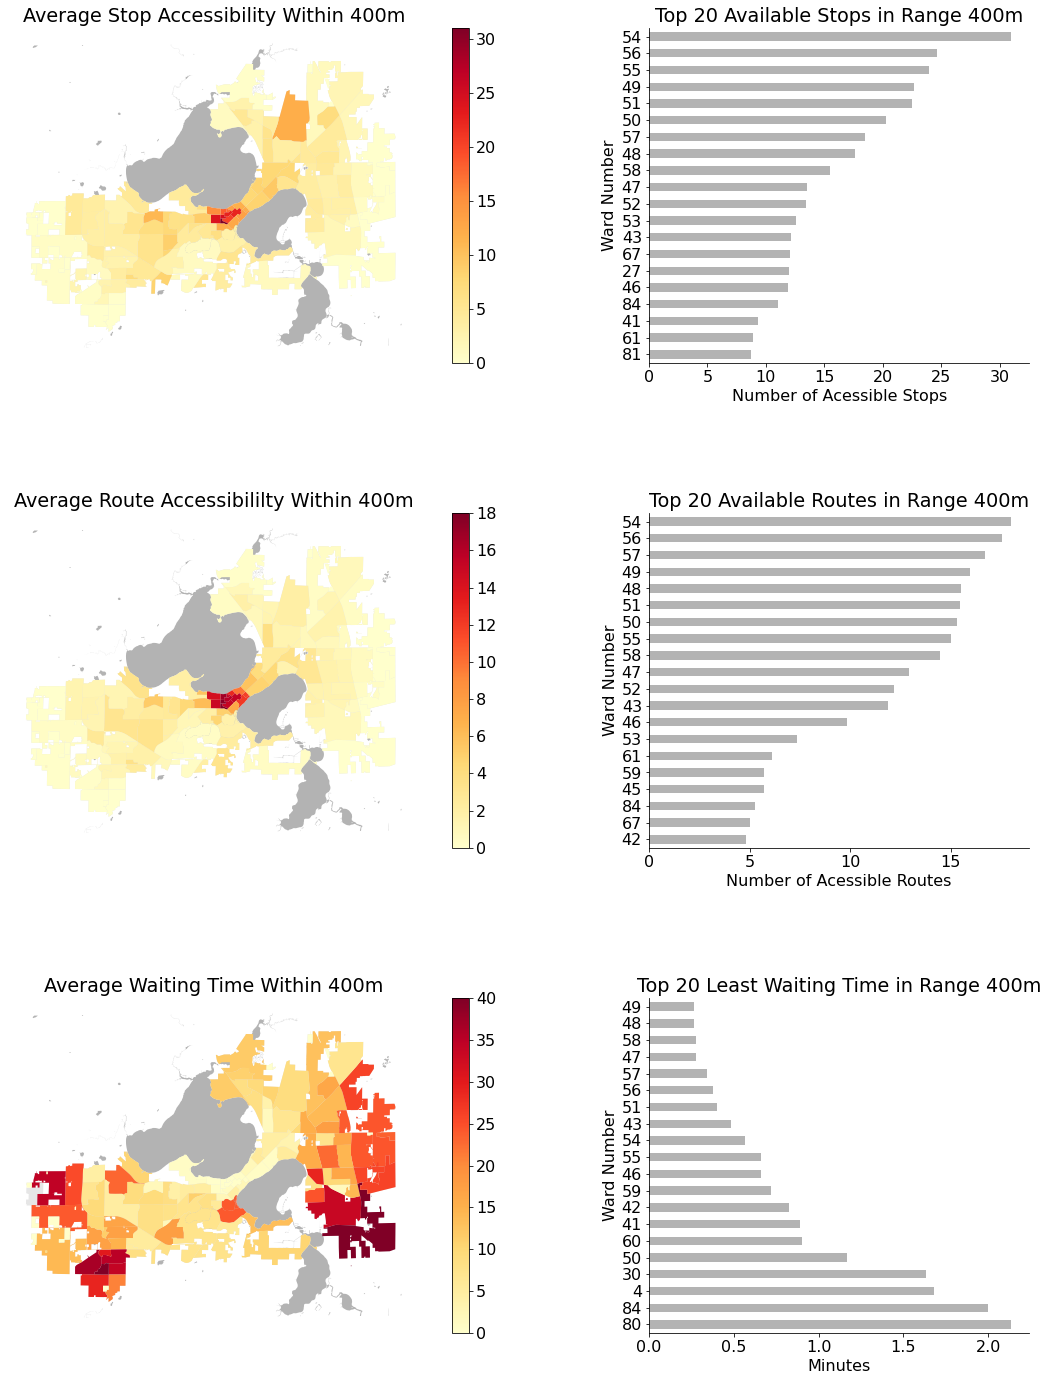

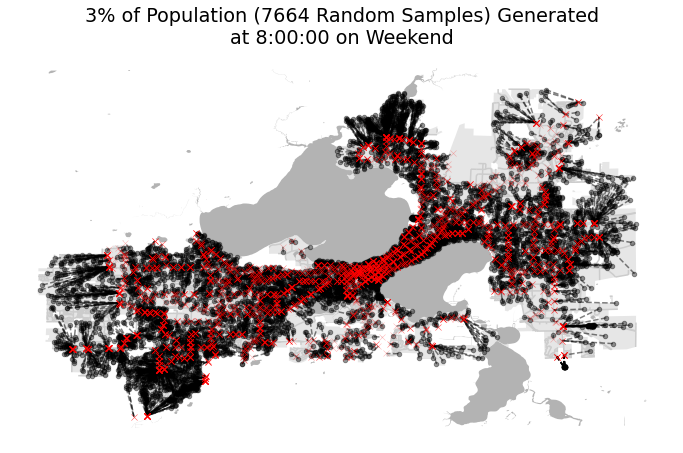

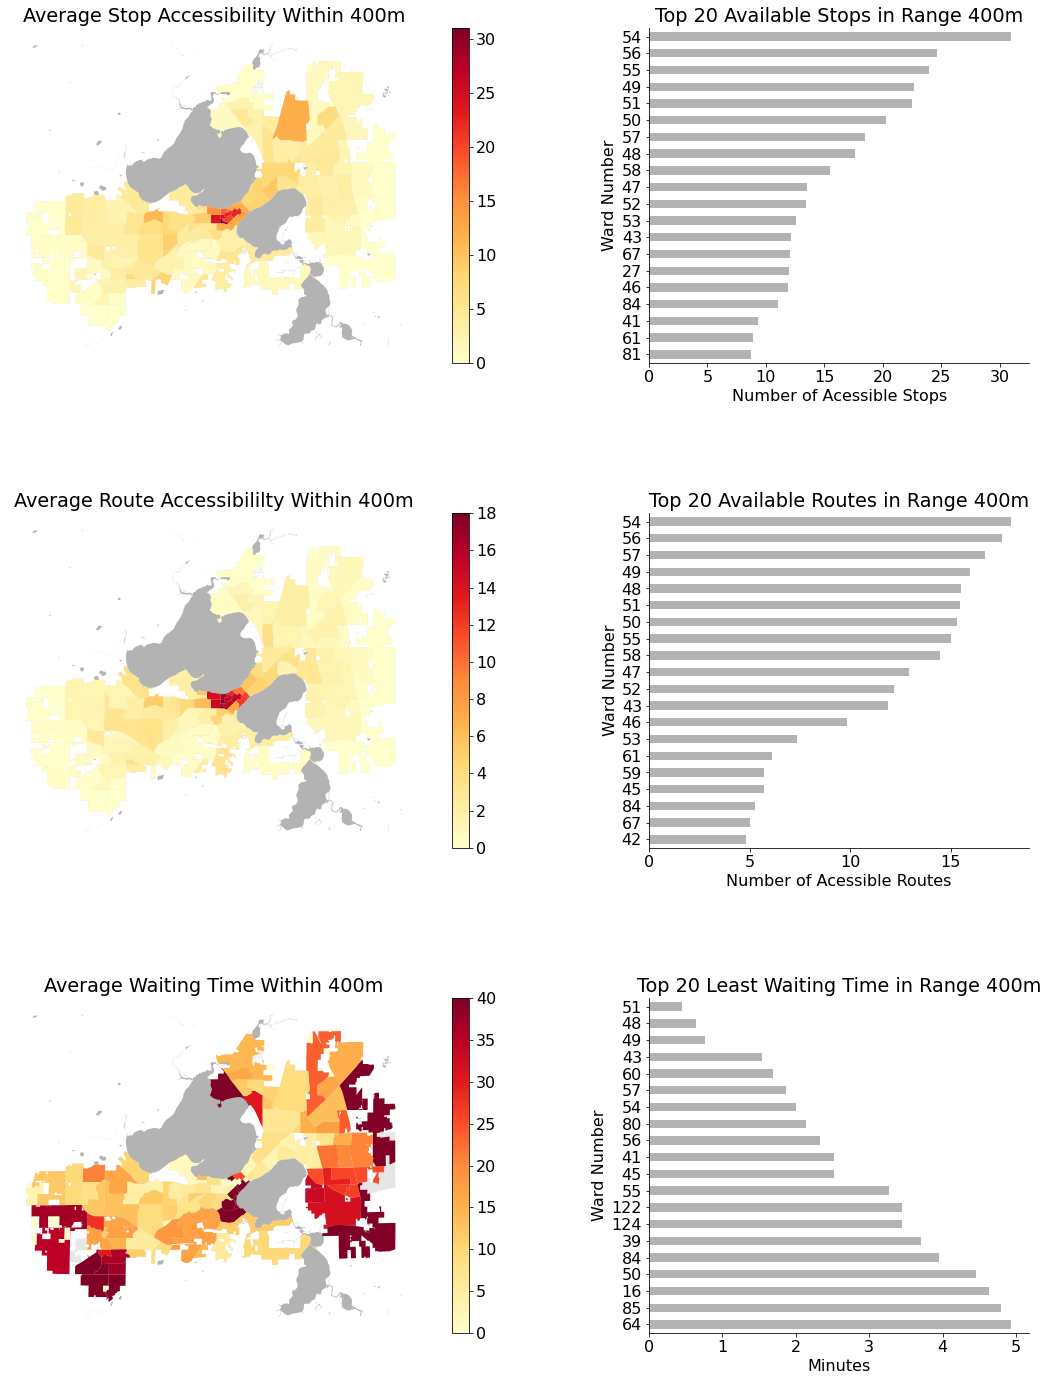

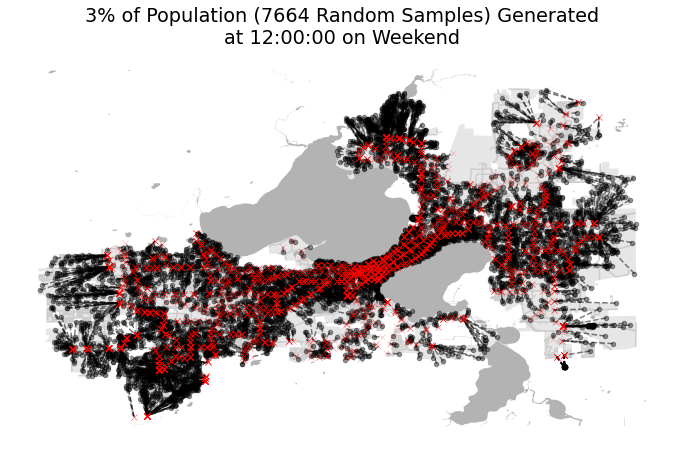

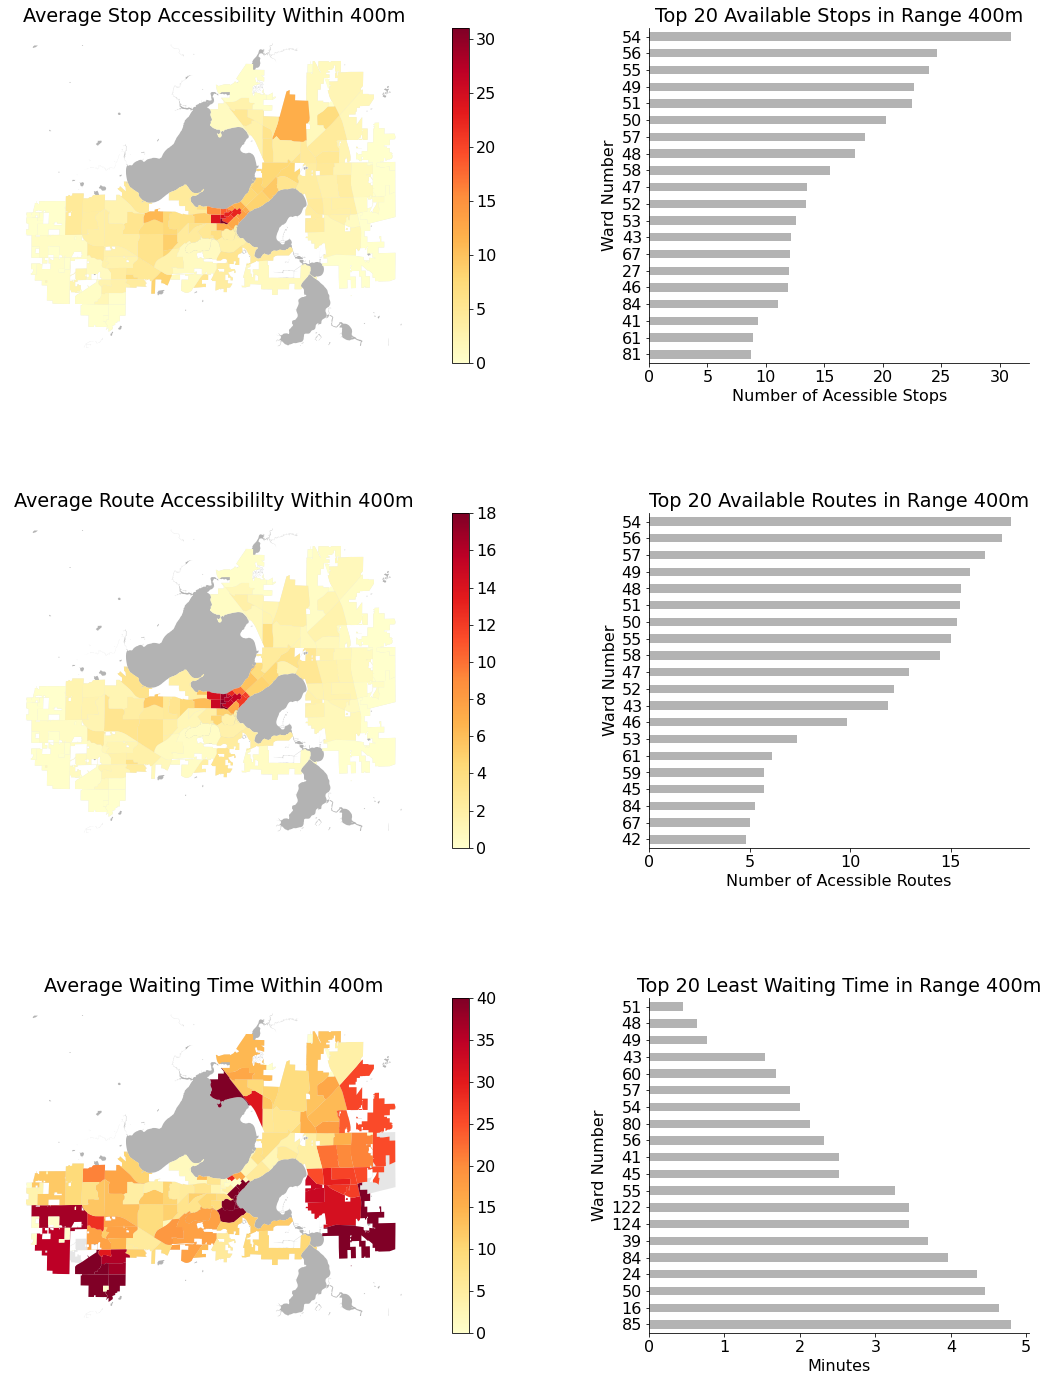

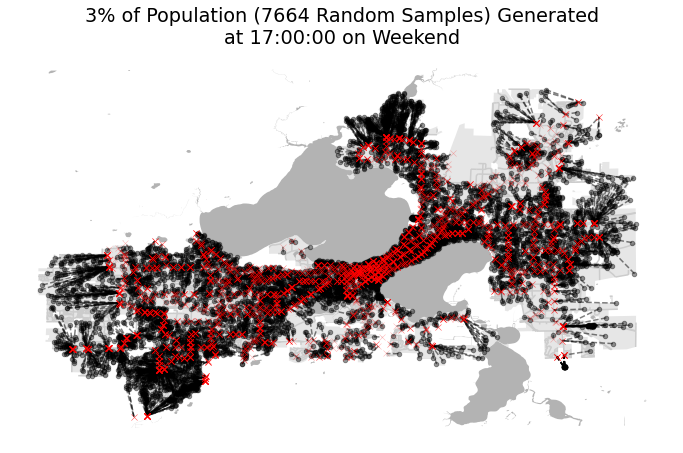

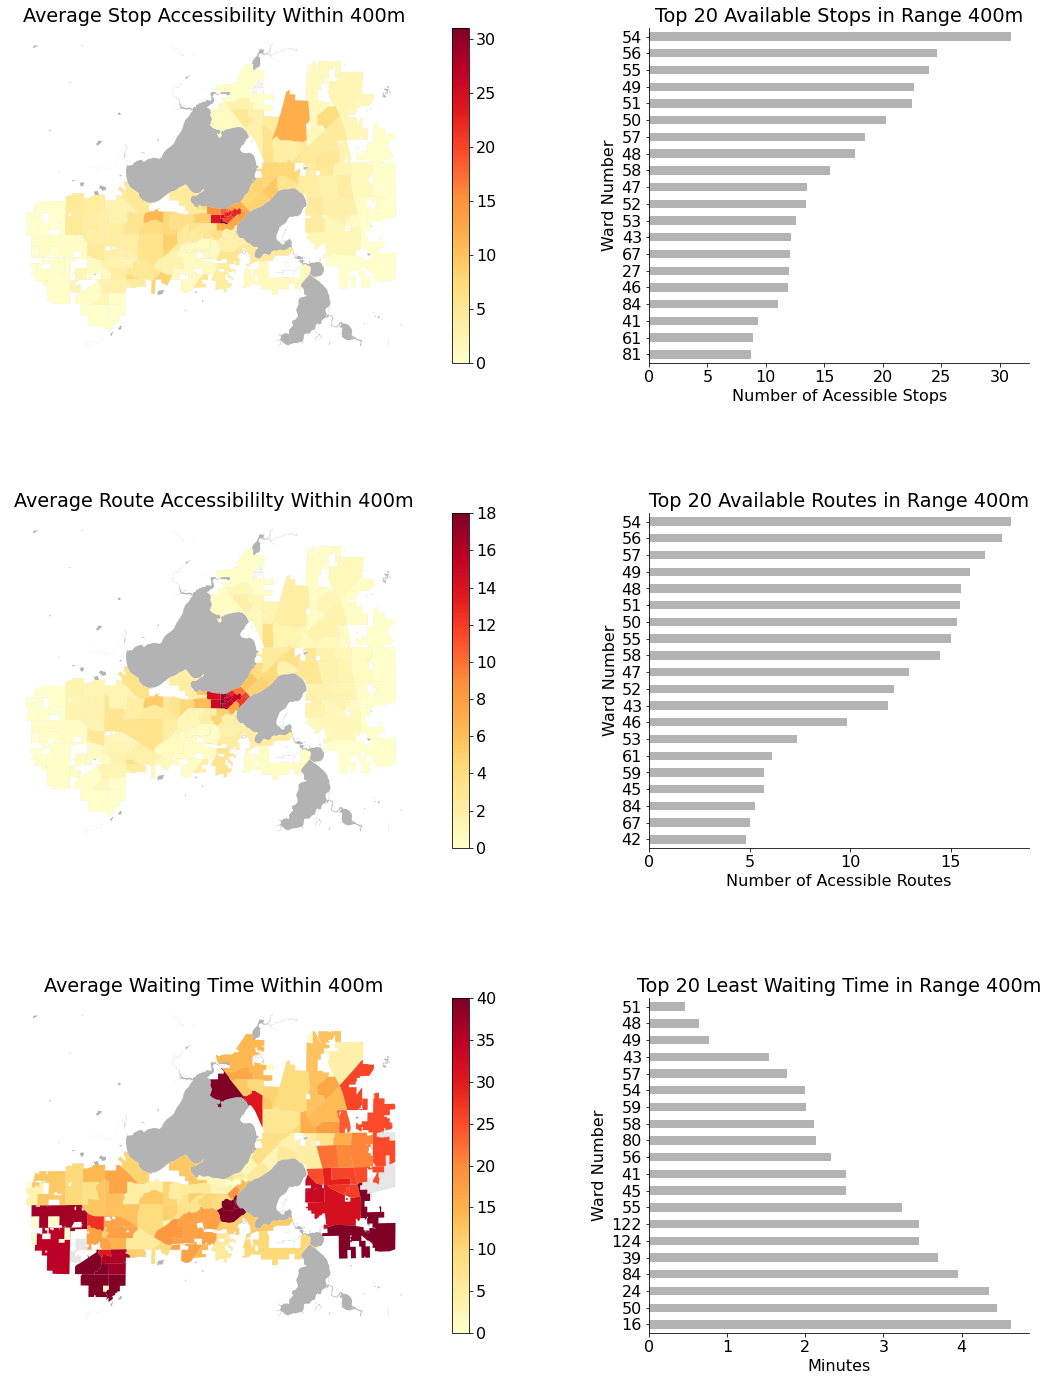

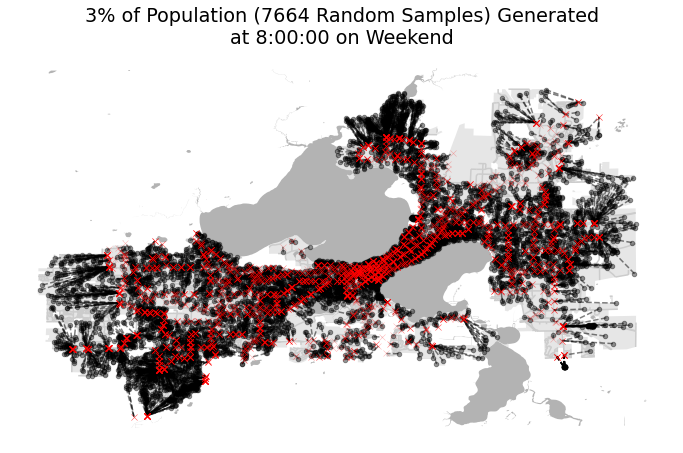

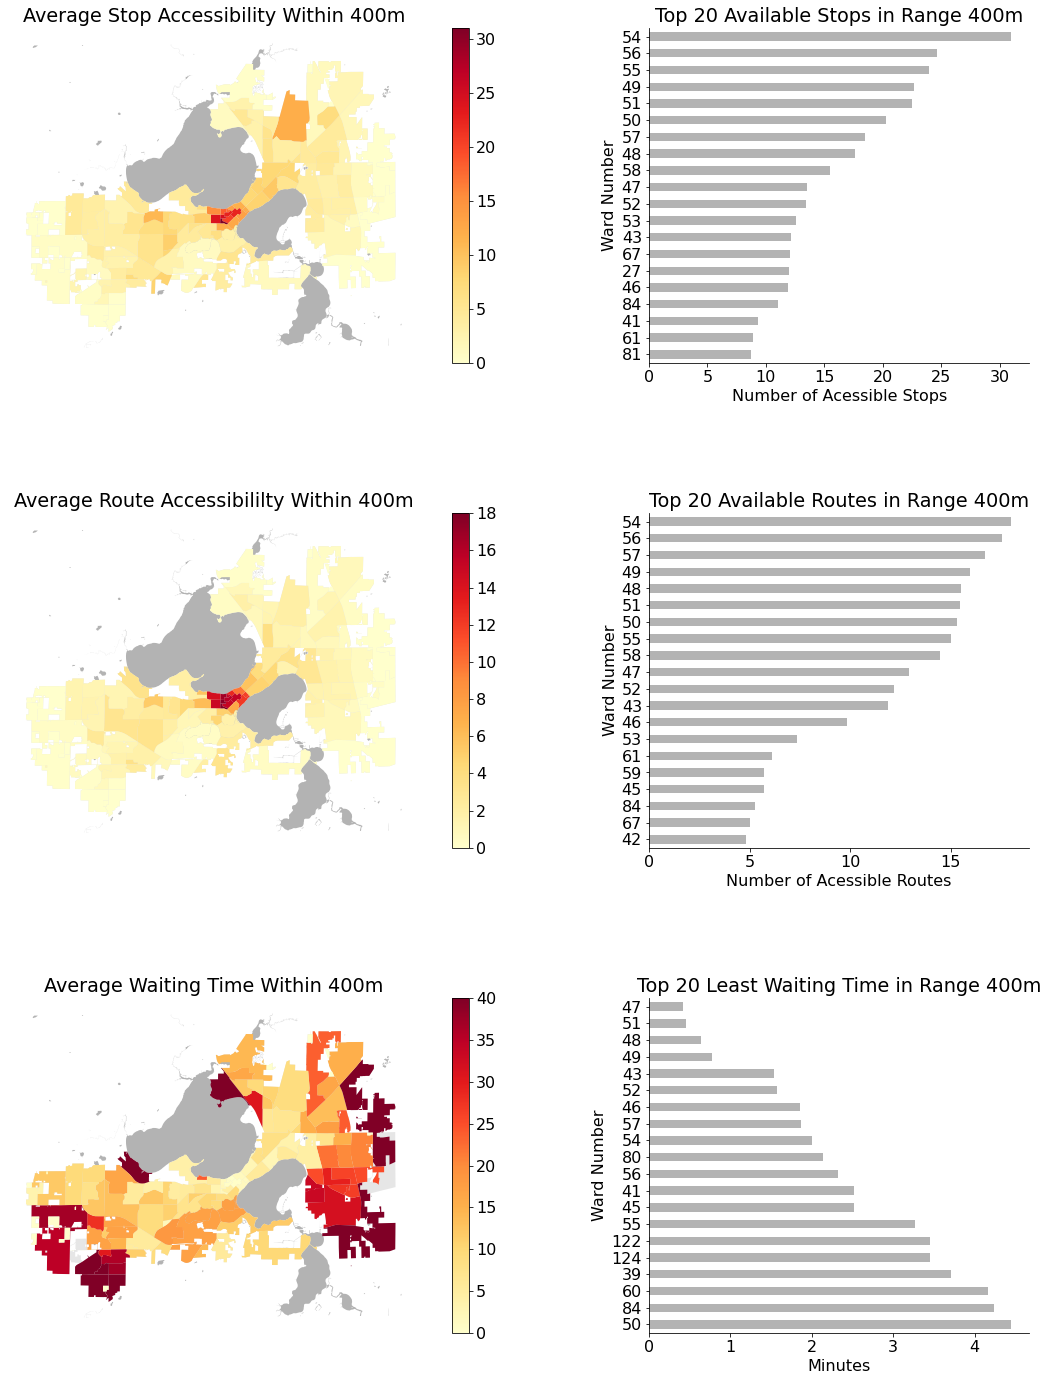

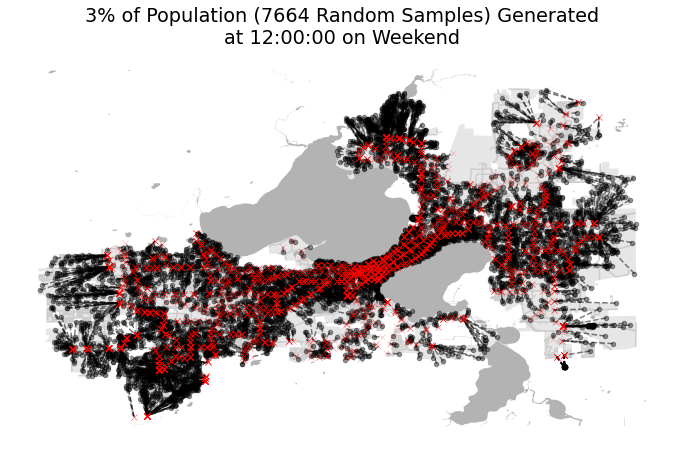

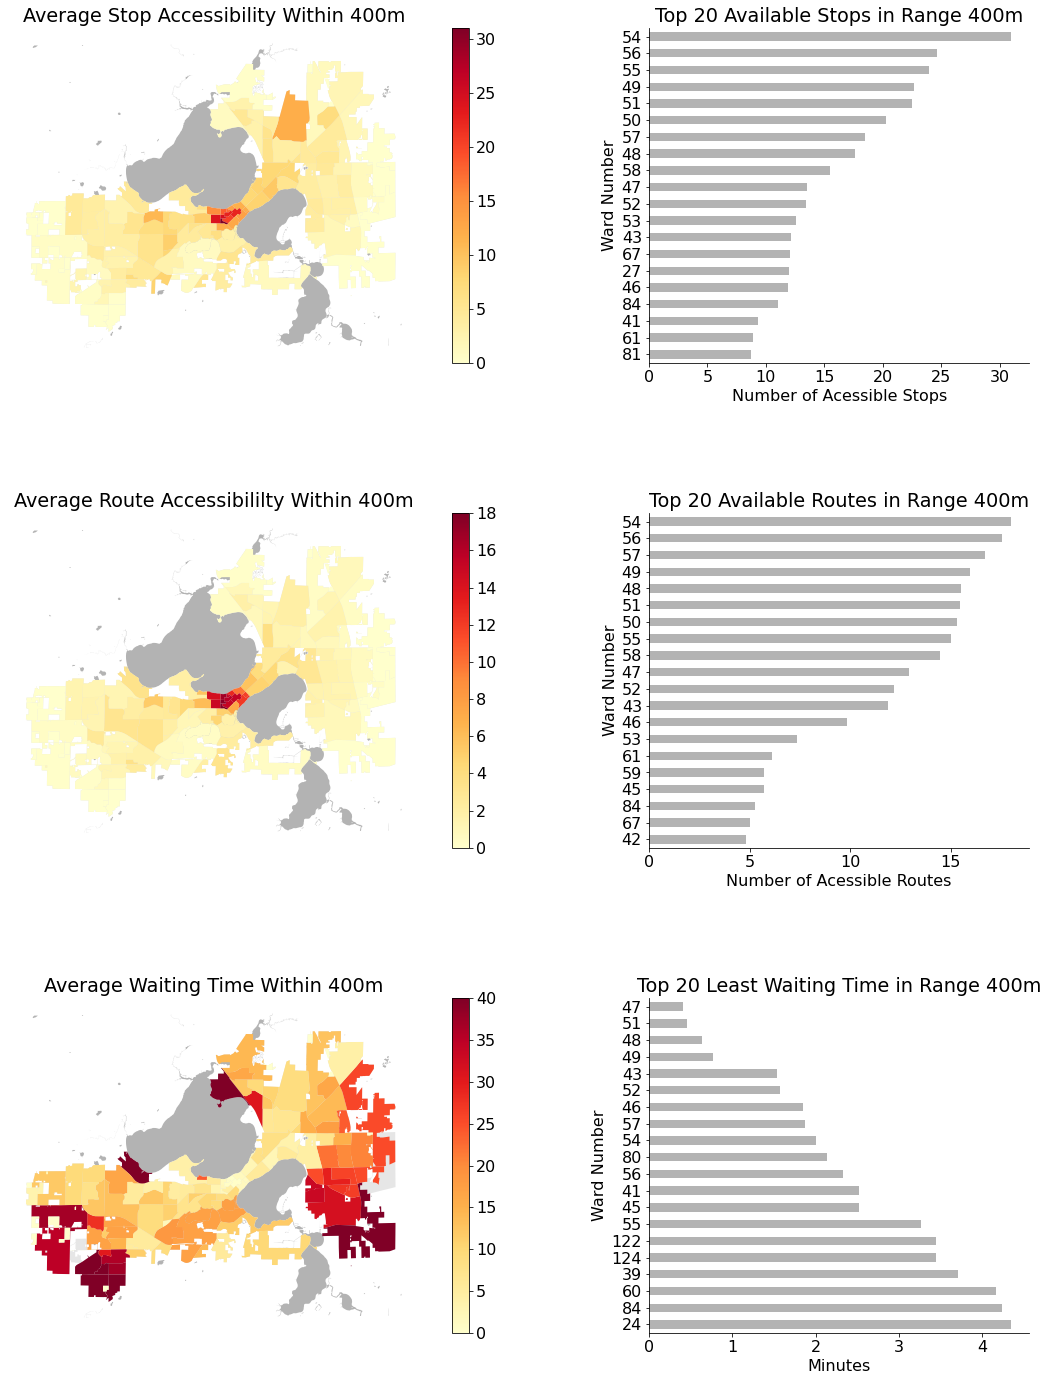

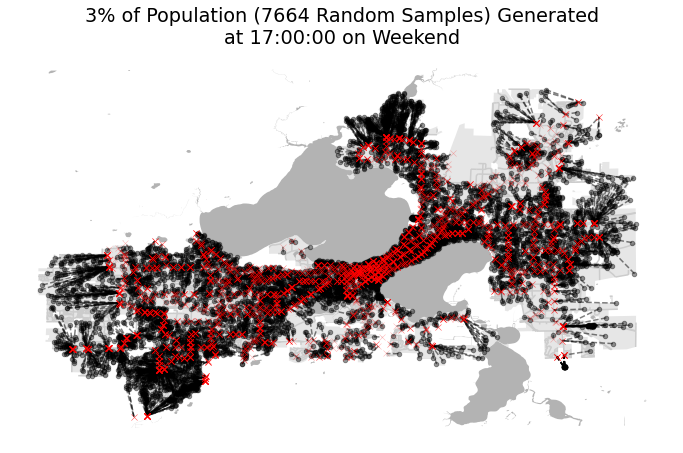

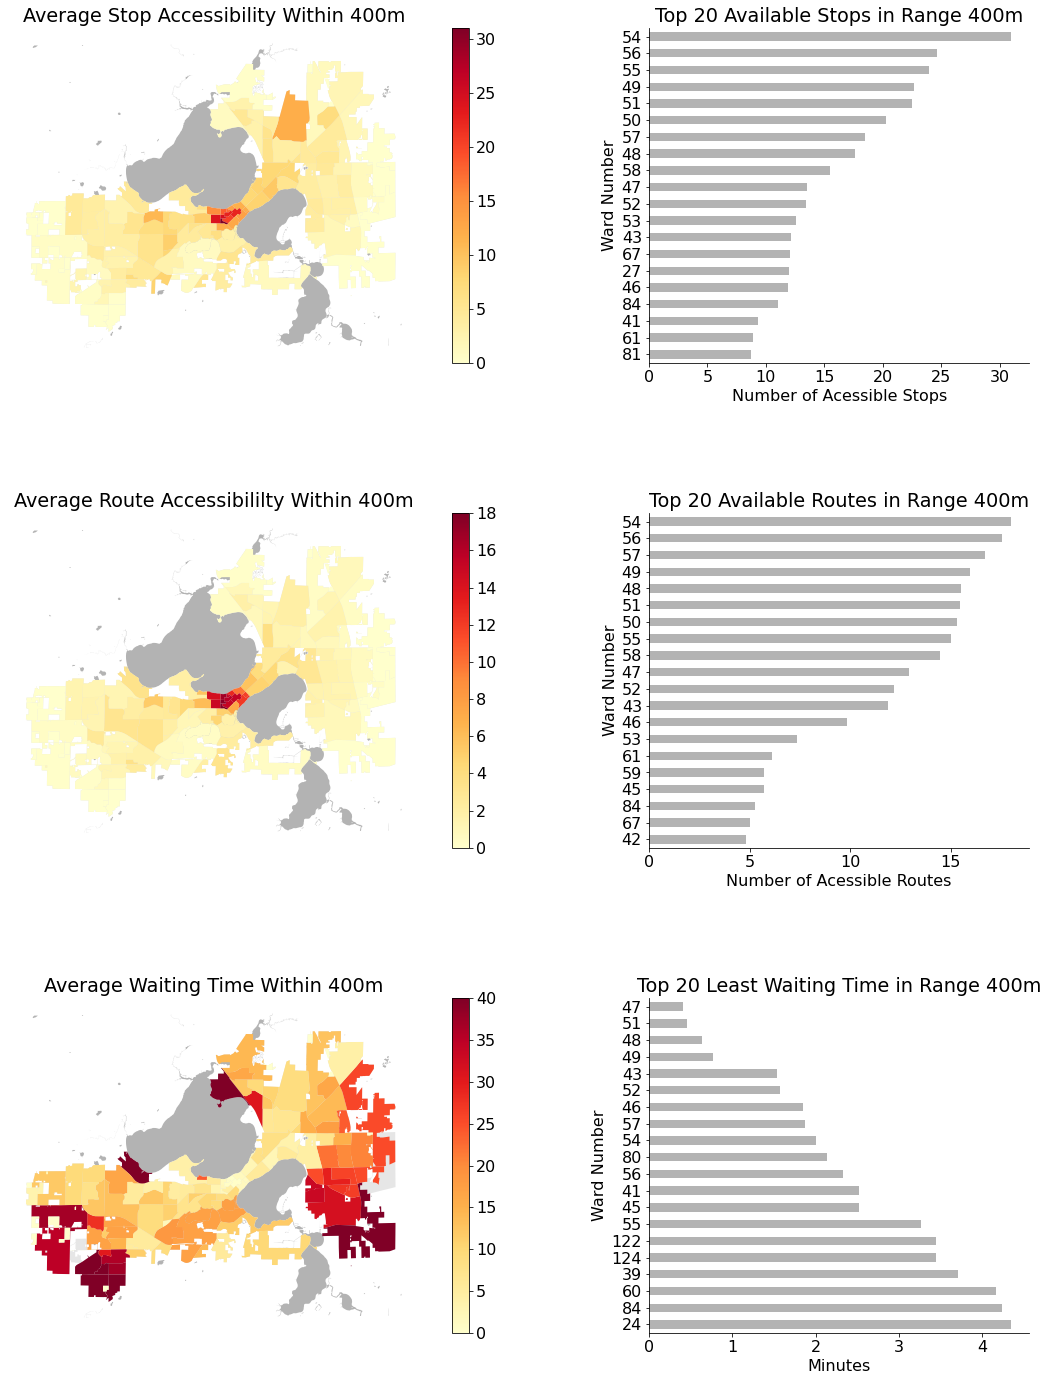

In [189]:
def gen_report(t, serv,
               wards_df, pops_df, stops_df, stop_times_df, trips_df,
               route_remove=None, stop_remove=None,
               num_points=None, perc_pop=None, coords=None, threshold=400):

    dt = t.split(":")
    td = datetime.time(hour=int(dt[0]),
                       minute=int(dt[1]),
                       second=int(dt[2]))

    categories = [
        "num_available_stops (within {}m)".format(threshold),
        "num_available_routes (within {}m)".format(threshold),
        "minutes_wait",
        # "distance (nearest, in meters)"
        # travel time   -> increase/decrease
        # area_coverage -> increase/decrease
    ]

    if coords == None:
        pts, df = generate_sim(td, serv,
                               wards_df, pops_df, stops_df, stop_times_df, trips_df,
                               num_points=num_points ,perc_pop=perc_pop,
                               threshold=threshold)
    else:
        pts, df = generate_sim(td, serv,
                               wards_df, pops_df, stops_df, stop_times_df, trips_df,
                               num_points=num_points ,perc_pop=perc_pop,
                               threshold=threshold, coords=coords)



    cnt = sum([len(val) for key, val in pts.items()])

    # geoplot
    ##################################################################
    fig, ax = plt.subplots(figsize=(12, 10))
    city.plot(ax=ax, color="0.9")
    water.plot(ax=ax, color="0.7")
    street.plot(ax=ax, color="0.8")

    dot_size = 20
    # --------- plot random points ---------
    points = plot_random(pts, ax=ax, s=dot_size, zorder=5, alpha=0.4)

    # --------- plot bus stops ---------
    # stops.plot.scatter("lon", "lat", ax=ax, c=colors, s=35, zorder=5, alpha=0.4, marker='o', facecolor="None")
    plt.plot(df["stop_lon (nearest)"], df["stop_lat (nearest)"], 'x',
             markersize=dot_size*0.3, markerfacecolor="None",
             markeredgecolor="red", markeredgewidth=0.5,
             alpha=0.3, zorder=5, label="Bus Stop")

    # --------- draw lines between pts and stops ---------
    connect_to_stops(ax, df)

    # --------- save figure to file ---------
    # TODO: when save, uncomment this
    ax.set_axis_off()

    if num_points != None:
        ax.set_title(str(cnt) + " Random Samples\nat " + t + " on " + get_service_type(serv))
                    # + get_full_time(t) + get_service_type(serv), size=19)
    else:
        ax.set_title(str(perc_pop) + "% of Population (" + str(cnt) + " Random Samples) Generated\nat " +
                     t + " on " + get_service_type(serv))
                    # + get_full_time(t) + get_service_type(serv), size=19

    if not os.path.exists("sim_sample"):
        os.mkdir("sim_sample")

    current_time = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d_%H-%M-%S')
    dirname = current_time[:current_time.index("_")]

    if not os.path.exists(os.path.join("sim_sample", dirname)):
        os.mkdir(os.path.join("sim_sample", dirname))

    plt.savefig(os.path.join("sim_sample",
                             dirname,
                            "at" + (current_time[current_time.index("_"):] + "-Geo.png")),
                dpi=300, bbox_inches="tight")

    # data plot
    ##################################################################

    nrows = 3
    ncols = 2

    # generate report
    fig, ((ax0, ax1),
          (ax2, ax3),
          (ax4, ax5)) = plt.subplots(nrows=nrows, ncols=ncols,
                                     figsize=(20, 24),
                                     gridspec_kw={'width_ratios': [5, 3]})
    plt.rcParams["font.size"] = 16
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.right'] = False
    plt.subplots_adjust(hspace=0.45)

    avg_stops = []
    avg_routes = []
    avg_minutes = []

    plot_df = pd.DataFrame(index=pts.keys())

    for ward in pts.keys():
        temp_df = df[df["wards"].isin([ward])]
        avg_stops.append(temp_df[categories[0]].mean())
        avg_routes.append(temp_df[categories[1]].mean())
        avg_minutes.append(temp_df[categories[2]].mean())

    plot_df["average_stops"] = avg_stops
    plot_df["average_routes"] = avg_routes
    plot_df["average_minutes"] = avg_minutes

    # RIGHT

    s1 = plot_df["average_stops"].sort_values(ascending=False)[:20]
    # s1["others"] = (plot_df["average_stops"].sort_values(ascending=False)[20:]).sum()

    s2 = plot_df["average_routes"].sort_values(ascending=False)[:20]
    # s2["others"] = (plot_df["average_routes"].sort_values(ascending=False)[20:]).sum()

    s3 = plot_df["average_minutes"].sort_values(ascending=True)[:20]
    # s3["others"] = (plot_df["average_minutes"].sort_values(ascending=True)[20:]).sum()

    s1.plot.barh(ax=ax1, color="0.7", linewidth=0.5)
    ax1.invert_yaxis()
    s2.plot.barh(ax=ax3, color="0.7", linewidth=0.5)
    ax3.invert_yaxis()
    s3.plot.barh(ax=ax5, color="0.7", linewidth=0.5)
    ax5.invert_yaxis()

    ax1.set_title("Top 20 Available Stops in Range {}m".format(threshold))
    ax1.set_xlabel("Number of Acessible Stops")
    ax1.set_ylabel("Ward Number")

    ax3.set_title("Top 20 Available Routes in Range {}m".format(threshold))
    ax3.set_xlabel("Number of Acessible Routes")
    ax3.set_ylabel("Ward Number")

    ax5.set_title("Top 20 Least Waiting Time in Range {}m".format(threshold))
    ax5.set_xlabel("Minutes")
    ax5.set_ylabel("Ward Number")


    # LEFT
    city.plot(ax=ax0, color="0.9")
    water.plot(ax=ax0, color="0.7")

    city.plot(ax=ax2, color="0.9")
    water.plot(ax=ax2, color="0.7")

    city.plot(ax=ax4, color="0.9")
    water.plot(ax=ax4, color="0.7")

    temp = wards_df.copy()
    avg_stops = []
    avg_routes = []
    avg_minutes = []
    for idx, row in temp.iterrows():
        ww = row["WARD"]
        try:
            avg_stops.append(plot_df[plot_df.index == ww].loc[ww, "average_stops"])
            avg_routes.append(plot_df[plot_df.index == ww].loc[ww, "average_routes"])
            avg_minutes.append(plot_df[plot_df.index == ww].loc[ww, "average_minutes"])
        except KeyError:
            avg_stops.append(0)
            avg_routes.append(0)
            avg_minutes.append(0)

    temp["average_stops"] = avg_stops
    temp["average_routes"] = avg_routes
    temp["average_minutes"] = avg_minutes

    temp = temp.set_geometry("geometry")

    temp.plot(ax=ax0, column="average_stops", cmap='YlOrRd', legend=True)
    temp.plot(ax=ax2, column="average_routes", cmap='YlOrRd', legend=True)
    temp.plot(ax=ax4, column="average_minutes", cmap='YlOrRd', legend=True, vmax=40)

    ax0.set_title("Average Stop Accessibility Within {}m".format(threshold))
    ax0.set_axis_off()
    ax2.set_title("Average Route Accessibililty Within {}m".format(threshold))
    ax2.set_axis_off()
    ax4.set_title("Average Waiting Time Within {}m".format(threshold))
    ax4.set_axis_off()

    # ax.set_title("Population Map in Madison", size=18)
    if not os.path.exists("sim_sample"):
            os.mkdir("sim_sample")

    current_time = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d_%H-%M-%S')
    dirname = current_time[:current_time.index("_")]

    if not os.path.exists(os.path.join("sim_sample", dirname)):
        os.mkdir(os.path.join("sim_sample", dirname))

    plt.savefig(os.path.join("sim_sample",
                             dirname,
                            "at" + (current_time[current_time.index("_"):] + "-Data.png")),
                dpi=300, bbox_inches="tight")





    return [list(s1.index), list(s2.index), list(s3.index)], pts



ts = ["8:00:00", "12:00:00", "17:00:00"]
servs = ["wkd", "sat", "hol"]
pts = None
threshold = 400

top20s = []

for serv in servs:
    for t in ts:
        if pts == None:
            top20 , pts = gen_report(t, serv,
                                     wards, pop, stops_df, stop_times_df, trips_df,
                                     perc_pop=3, threshold=threshold)
        else:
            top20 , _ = gen_report(t, serv,
                                   wards, pop, stops_df, stop_times_df, trips_df,
                                   perc_pop=3, threshold=threshold, coords=pts)
        top20s.append(top20)

In [193]:
len(top20s)

9

In [145]:
# simulation should:
# 1. for bus routes:
#    - determine removal of one bus route that has the lowest impact
#    - simulations:
#        - using the same generated coordinates for each simulations
#            - 3 different service types
#            - 24 hours a day
#
# 2. for stops:
#    - determine removal of one stop that has the lowest impact
#    - simulations:
#        - using the same generated coordinates for each simulations
#           -

# t, serv,
# wards_df, pops_df, stops_df, stop_times_df, trips_df,
# num_points=None, perc_pop=None, coords=None, threshold=400, geo_plot=False

# note:
# times = a list of "HH:MM:SS"
# bar_plot:
#   1. nearest bus stop distance
#   2. num available stops within threshold
#   3. num available routes within threshold
#   4. minutes wait
def generate_report(times, servs,
                    wards_df, pops_df, stops_df, stop_times_df, trips_df,
                    route_remove=None, stop_remove=None,
                    num_points=None, perc_pop=None, coords=None, threshold=400,
                    geo_plot=False):
    # TODO:
    # do bar plot and geo plot differentiate by colormap

    # convert time string to datetime object
    ts = []
    for t in times:
        dt = t.split(":")
        ts.append(datetime.time(hour = int(dt[0]),
                                minute = int(dt[1]),
                                second = int(dt[2])))

    # analysis based on wards
    categories = [
        "distance (nearest, in meters)",
        "num_available_stops (within {}m)".format(threshold),  # Diverging Bars
        "num_available_routes (within {}m)".format(threshold),  # Diverging Bars
        "available_routes (within {}m)".format(threshold),  # matrix
        "minutes_wait"  # Diverging Bars
        # travel time   -> increase/decrease
        # area_coverage -> increase/decrease
    ]

    #################################################################
    #####################    setting for plt    #####################
    #################################################################
    plt.rcParams["font.size"] = 16
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.right'] = False
    plt.subplots_adjust(hspace=0.45, wspace=0.55)

    xlabels = [
        "Distance (in Meter)",
        "Number of Acessible Stops",
        "Number of Acessible Routes",
        "Bus Route Number",
        "Minutes"
    ]
    title_size = 16
    label_size = 14
    nrows      = len(categories) * len(ts) * len(servs)
    ncols      = 3   # top 10, geoplot, bottom 10


    #################################################################
    ###################    plotting bar plot    #####################
    #################################################################
    pts = coords  # if coordinates of riders are given as formatted (a dict)
    stops = None  # for plotting
    # case when both remove_route and remove_stop are None
    for serv in servs:
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6.5*ncols, 8*nrows))
        for i in range(nrows):
            if pts == None:
                # generate_sim(t, serv,
                # wards_df, pops_df, stops_df, stop_times_df, trips_df,
                # num_points=None, perc_pop=None, coords=None, threshold=400, geo_plot=False):
                pts, df = generate_sim(ts[i], serv,
                                       wards_df, pops_df, stops_df, stop_times_df, trips_df,
                                       num_points=num_points ,perc_pop=perc_pop,
                                       threshold=threshold, geo_plot=geo_plot)
            else:
                _, df = generate_sim(ts[i], serv,
                                     wards_df, pops_df, stops_df, stop_times_df, trips_df,
                                     num_points=num_points , perc_pop=perc_pop,
                                     coords=pts, threshold=threshold, geo_plot=geo_plot)
            stops = df  # for plotting

            for j in range(ncols):

                ax = axes[i][j]




                #################################################################
                #####################      plot setting      ####################
                #################################################################
                if i == 0 and servs.index(serv) == 0:
                    ax.set_title(categories[j] + "\nAt " + times[i], size=title_size)
                else:
                    ax.set_title(times[i], size=title_size)
                    # TODO: set titles for categories
                    # else set title for time
                if i == nrows - 1:
                    ax.set_xlabel(xlabels[j], size=label_size)

        plt.savefig("temp-{}.png".format(get_service_type(serv)), dpi=300, bbox_inches="tight")

    #################################################################
    #####################    plot background     ####################
    #################################################################
    if geo_plot:
        fig, ax = plt.subplots(figsize=(12, 10))
        city.plot(ax=ax, color="0.9")
        water.plot(ax=ax, color="0.7")
        street.plot(ax=ax, color="0.8")

        dot_size = 20
        # --------- plot random points ---------
        start = time.time()
        points = plot_random(pts, ax=ax, s=dot_size, zorder=5, alpha=0.4)
        end = time.time()
        print("plot random points " + str(round((end - start) * 1000, 2)) + "ms")

        # --------- plot bus stops ---------
        start = time.time()
        # stops.plot.scatter("lon", "lat", ax=ax, c=colors, s=35, zorder=5, alpha=0.4, marker='o', facecolor="None")
        plt.plot(stops["stop_lon (nearest)"], stops["stop_lat (nearest)"], 'x',
                 markersize=dot_size*0.3, markerfacecolor="None",
                 markeredgecolor="red", markeredgewidth=0.5,
                 alpha=0.3, zorder=5, label="Bus Stop")
        end = time.time()
        print("plot bus stops " + str(round((end - start) * 1000, 2)) + "ms")

        # --------- draw lines between pts and stops ---------
        start = time.time()
        connect_to_stops(ax, stops)

        end = time.time()
        print("draw lines between pts and stops " + str(round((end - start) * 1000, 2)) + "ms")

        # --------- save figure to file ---------
        # TODO: when save, uncomment this
        start = time.time()
        ax.set_axis_off()

        if num_points != None:
            ax.set_title(str(cnt) + " Random Samples")
                        # + get_full_time(t) + get_service_type(serv), size=19)
        else:
            ax.set_title(str(perc_pop) + "% of Population Generated")
                        # + get_full_time(t) + get_service_type(serv), size=19

        if not os.path.exists("sim_sample"):
            os.mkdir("sim_sample")

        current_time = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d_%H-%M-%S')
        dirname = current_time[:current_time.index("_")]

        if not os.path.exists(os.path.join("sim_sample", dirname)):
            os.mkdir(os.path.join("sim_sample", dirname))

        plt.savefig(os.path.join("sim_sample",
                                 dirname,
                                (current_time[current_time.index("_"):] + ".png")),
                    dpi=300, bbox_inches="tight")
        end = time.time()
        print("saving figure " + str(round((end - start) * 1000, 2)) + "ms")

    return "Yay u did it!"

# ts = ["7:00:00",  "8:00:00",  "9:00:00",
#       "11:00:00", "12:00:00", "13:00:00",
#       "16:00:00", "17:00:00", "18:00:00"]
ts = ["7:00:00", "12:00:00"]
servs = ["wkd", "sat"]


# times, servs,
# wards_df, pops_df, stops_df, stop_times_df, trips_df,
# route_remove=None, stop_remove=None,
# num_points=None, perc_pop=None, coords=None, threshold=400,
# geo_plot=False
generate_report(ts, servs,
                wards, pop, stops_df, stop_times_df, trips_df,
                perc_pop=0.05, geo_plot=True)

58           0.033333
50           0.050000
54           0.050000
57           0.116667
56           0.116667
87           0.150000
41           0.200000
48           0.266667
49           0.266667
47           0.283333
51           0.300000
3            0.366667
45           0.433333
55           0.450000
30           0.450000
46           0.483333
43           0.483333
14           0.600000
42           0.616667
4            0.783333
others    3351.583333
Name: average_minutes, dtype: float64

In [38]:
wards.head(5)

OBJECTID  WARD  ALD_DIST  SUP_DIST  ASM_DIST  SEN_DIST ADDRESS HANDICAP_A  \
1     19468     2        16        24        47        16    None       None   
2     19469     3        16        24        47        16    None       None   
3     19470     4        16        24        48        16    None       None   
4     19471     5        16        16        48        16    None       None   
5     19472     6        16        16        48        16    None       None   

  SPEC_COMME PHONE_NO BALLOT_COL    SHAPESTAre    SHAPESTLen  \
1       None     None       None  7.327044e+07  52985.941294   
2       None     None       None  8.318129e+06  13256.832292   
3       None     None       None  7.036292e+06  14714.085520   
4       None     None       None  1.367441e+07  20753.346709   
5       None     None       None  1.670246e+07  19342.753138   

                                            geometry  
1  POLYGON ((-89.30625 43.07302, -89.30614 43.072...  
2  POLYGON ((-89.27786 43.06610, -89.27840 43.066...  
3  POLYGON ((-89.29143 43.06682, -89.29143 43.066...  
4  POLYGON ((-89.28662 43.07347, -89.28744 43.073...  
5  POLYGON ((-89.28030 43.07398, -89.28043 43.073...

<ipython-input-10-5555d9155a27>:56: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coord = df["geometry"].centroid
<ipython-input-10-5555d9155a27>:56: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coord = df["geometry"].centroid
<ipython-input-10-5555d9155a27>:56: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coord = df["geometry"].centroid
<ipython-input-10-5555d9155a27>:56: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coord = df["

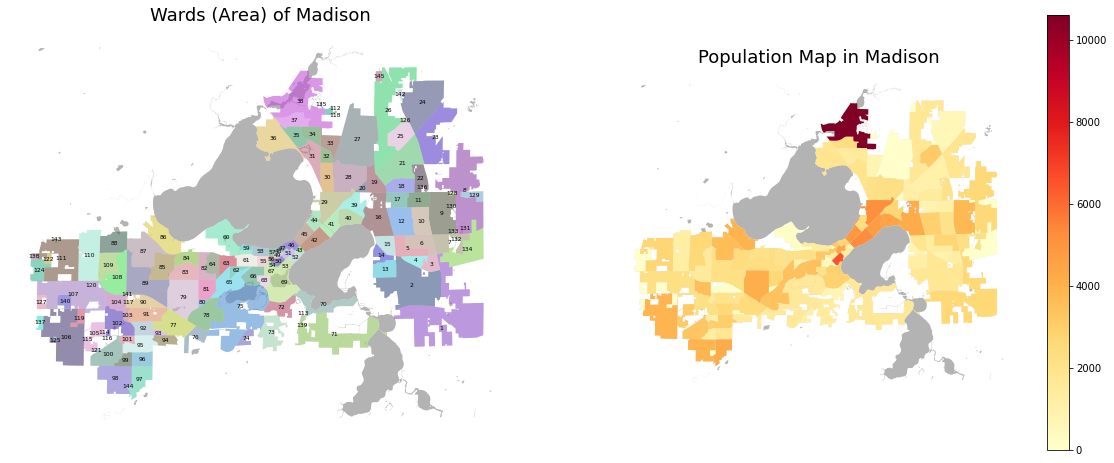

In [10]:
#################################################################
#################################################################
############# PLOT population_plot.png ##########################
#################################################################
#################################################################

fig, (ax0, ax1) = plt.subplots(figsize=(20, 8), ncols=2)
city.plot(ax=ax1, color="0.9")
water.plot(ax=ax1, color="0.7")

temp = wards.copy()
population = {}

for idx, row in pop.iterrows():
    population[int(row["Ward"])] = row["total"]

pop_temp = []
for idx, row in temp.iterrows():
    ww = row["WARD"]
    pop_temp.append(population[ww])

temp["population"] = pop_temp

temp = temp.set_geometry("geometry")
temp.plot(ax=ax1, column="population", cmap='YlOrRd', legend=True)


ax1.set_title("Population Map in Madison", size=18)
ax1.set_axis_off()

##############################################

city.plot(ax=ax0, color="0.9")
water.plot(ax=ax0, color="0.7")
# street.plot(ax=ax, color="0.8")

www = []
for idx, row in wards.iterrows():

    if row["WARD"] in www:
        continue

    # randomly generate colors
    r = lambda: random.randint(0,255)
    c = '#%02X%02X%02X' % (r(),r(),r())
    df = wards[wards["WARD"].isin([row["WARD"]])]
    df.plot(ax=ax0, color=c, alpha=0.4)
    center = [0, 0]
    if len(df) > 1:
        for idx1, row1 in df.iterrows():
            center[0] += row1["geometry"].centroid.x
            center[1] += row1["geometry"].centroid.y
        center[0] = center[0] / len(df)
        center[1] = center[1] / len(df)
    else:
        coord = df["geometry"].centroid
        center = [coord.x, coord.y]

    # up:   105, 114, 112, 131, 113, 141
    # down: 115, 116, 118, 132, 139, 144, 125,
    # upper right: 133
    # lower left: 117

    if row["WARD"] in [105, 114, 133, 113, 141, 143]:
        ax0.text(center[0], center[1], str(row["WARD"]),
            ha="center", va="bottom", color="k", fontsize=6)
    elif row["WARD"] in [115, 116, 118, 132, 139, 144, 125]:
        ax0.text(center[0], center[1], str(row["WARD"]),
            ha="center", va="top", color="k", fontsize=6)
    elif row["WARD"] in  [112, 131]:
        ax0.text(center[0], center[1], str(row["WARD"]),
            ha="left", va="bottom", color="k", fontsize=6)
    elif row["WARD"] == 117:
        ax0.text(center[0], center[1], str(row["WARD"]),
            ha="right", va="top", color="k", fontsize=6)
    else:
        ax0.text(center[0], center[1], str(row["WARD"]),
            ha="center", va="center", color="k", fontsize=6)

    ax0.set_title("Wards (Area) of Madison", size=18)
    ax0.set_axis_off()

    www.append(row["WARD"])

# plt.savefig("wards_plot.png", dpi=300, bbox_inches="tight")


# plt.savefig("population_plot.png", dpi=300, bbox_inches="tight")


In [44]:
#################################################################
#################################################################
############# PLOT ward_plot.png ################################
#################################################################
#################################################################

fig, ax = plt.subplots(figsize=(12, 10))
city.plot(ax=ax, color="0.9")
water.plot(ax=ax, color="0.7")
# street.plot(ax=ax, color="0.8")

colors = []
www = []
for idx, row in wards.iterrows():

    if row["WARD"] in www:
        continue

    # randomly generate colors
    r = lambda: random.randint(0,255)
    c = '#%02X%02X%02X' % (r(),r(),r())
    colors.append(c)
    df = wards[wards["WARD"].isin([row["WARD"]])]
    df.plot(ax=ax, color=c, alpha=0.4)
    center = [0, 0]
    if len(df) > 1:
        for idx1, row1 in df.iterrows():
            center[0] += row1["geometry"].centroid.x
            center[1] += row1["geometry"].centroid.y
        center[0] = center[0] / len(df)
        center[1] = center[1] / len(df)
    else:
        coord = df["geometry"].centroid
        center = [coord.x, coord.y]

    # up:   105, 114, 112, 131, 113, 141
    # down: 115, 116, 118, 132, 139, 144, 125,
    # upper right: 133
    # lower left: 117

    if row["WARD"] in [105, 114, 133, 113, 141, 143]:
        ax.text(center[0], center[1], str(row["WARD"]),
            ha="center", va="bottom", color="k", fontsize=7.5)
    elif row["WARD"] in [115, 116, 118, 132, 139, 144, 125]:
        ax.text(center[0], center[1], str(row["WARD"]),
            ha="center", va="top", color="k", fontsize=7.5)
    elif row["WARD"] in  [112, 131]:
        ax.text(center[0], center[1], str(row["WARD"]),
            ha="left", va="bottom", color="k", fontsize=7.5)
    elif row["WARD"] == 117:
        ax.text(center[0], center[1], str(row["WARD"]),
            ha="right", va="top", color="k", fontsize=7.5)
    else:
        ax.text(center[0], center[1], str(row["WARD"]),
            ha="center", va="center", color="k", fontsize=7.5)

    # ax.set_title("Wards (Area) of Madison", size=18)
    # ax.set_axis_off()

    www.append(row["WARD"])

plt.savefig("wards_plot.png", dpi=300, bbox_inches="tight")

None

plot random points 879.79ms
plot bus stops 2406.87ms
draw lines between pts and stops 460.9ms
saving figure 1529.87ms
add routes to stops 1636.32ms
find soonest coming bus 17890.15ms
plot random points 673.55ms
plot bus stops 2125.32ms
draw lines between pts and stops 456.95ms
saving figure 1537.53ms
add routes to stops 1336.46ms
find soonest coming bus 17210.59ms
plot random points 648.3ms
plot bus stops 2232.1ms
draw lines between pts and stops 469.96ms
saving figure 1590.33ms
add routes to stops 1371.83ms
find soonest coming bus 17372.69ms
plot random points 644.59ms
plot bus stops 2170.08ms
draw lines between pts and stops 490.88ms
saving figure 1602.26ms
add routes to stops 1378.79ms
find soonest coming bus 13770.47ms
plot random points 658.21ms
plot bus stops 2262.78ms
draw lines between pts and stops 466.97ms
saving figure 1528.07ms
add routes to stops 1404.55ms
find soonest coming bus 13857.99ms
plot random points 662.52ms
plot bus stops 2236.78ms
draw lines between pts and sto

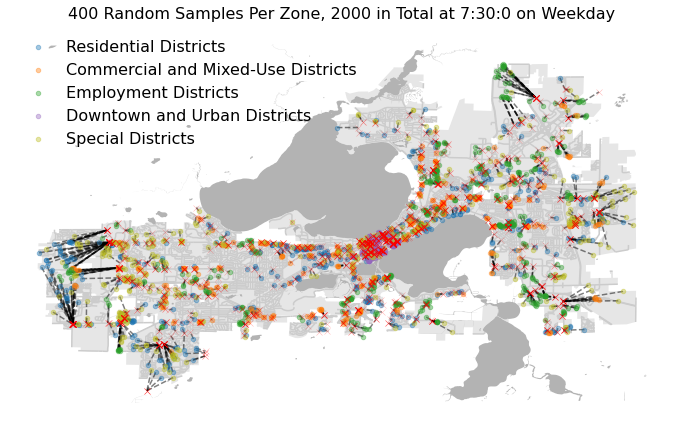

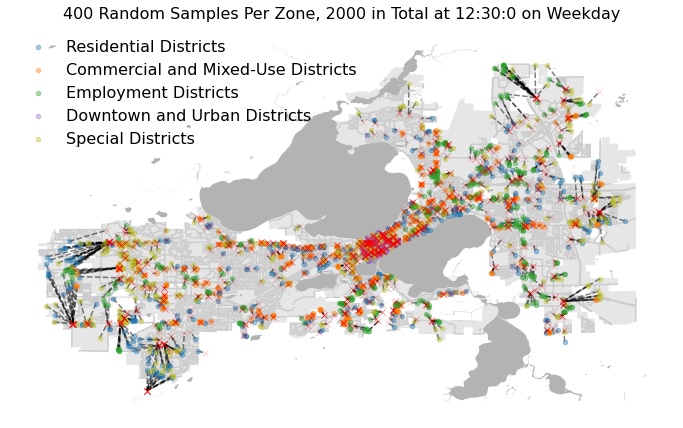

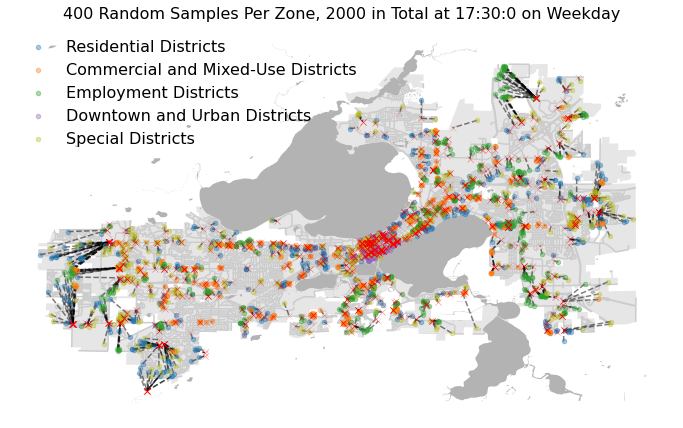

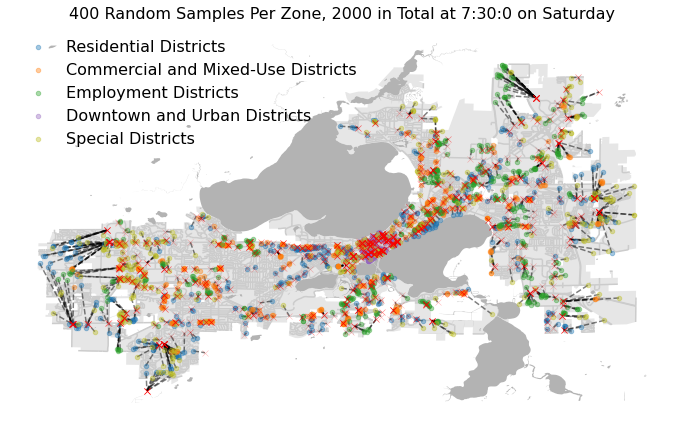

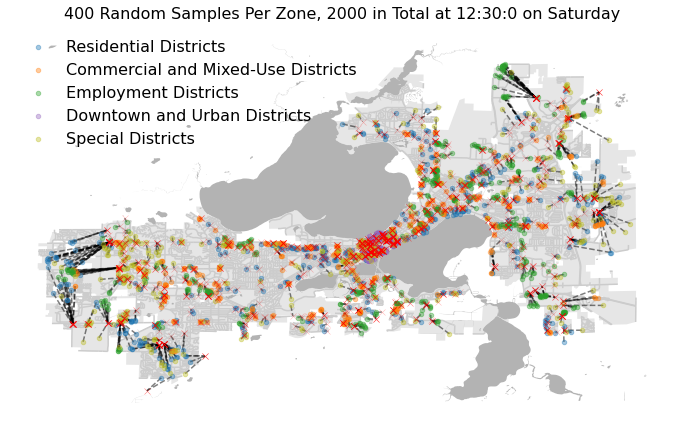

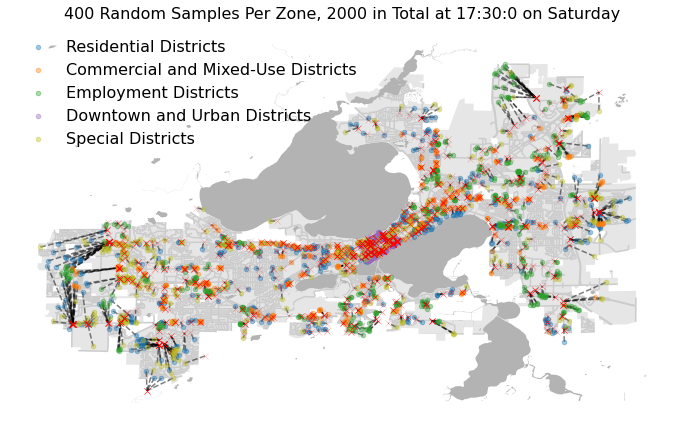

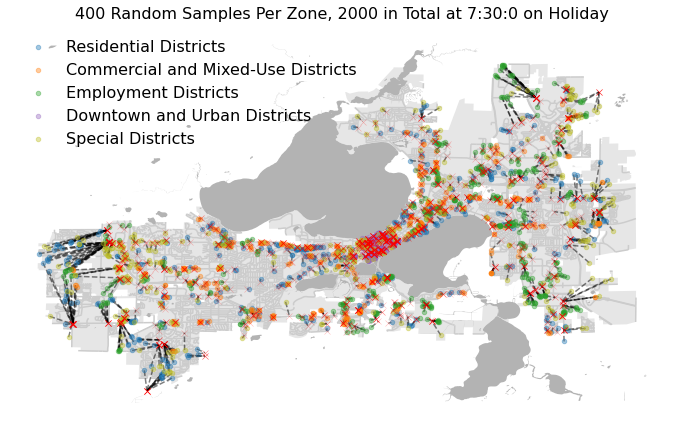

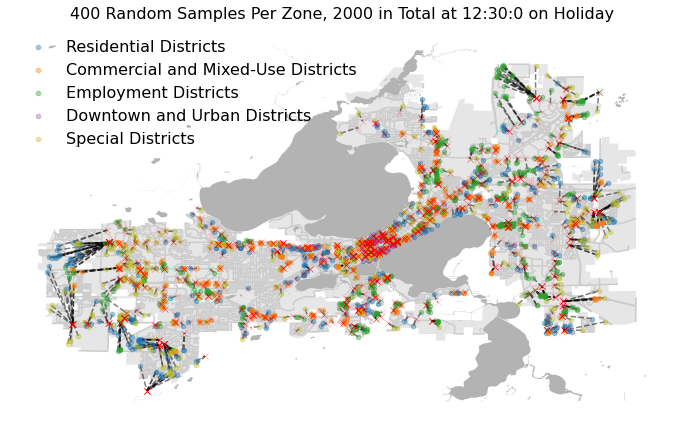

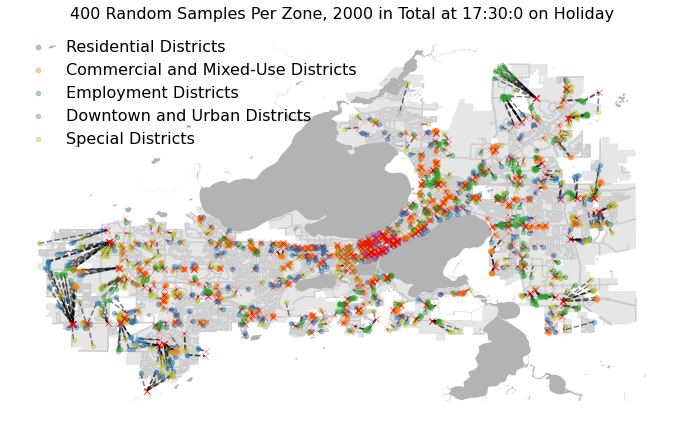

In [36]:
# start = time.time()
# s1 = generate_plot(400, datetime.time(7, 30, 00), "wkd")
# s2 = generate_plot(400, datetime.time(12, 30, 00), "wkd")
# s3 = generate_plot(400, datetime.time(17, 30, 00), "wkd")
# s4 = generate_plot(400, datetime.time(7, 30, 00), "sat")
# s5 = generate_plot(400, datetime.time(12, 30, 00), "sat")
# s6 = generate_plot(400, datetime.time(17, 30, 00), "sat")
# s7 = generate_plot(400, datetime.time(7, 30, 00), "hol")
# s8 = generate_plot(400, datetime.time(12, 30, 00), "hol")
# s9 = generate_plot(400, datetime.time(17, 30, 00), "hol")
# end = time.time()
# print("total execution time " + str(round((end - start) * 1000, 2)) + "ms")

In [37]:
# ds  = list(zone_category.keys())[:5]
# d1_1 = s1[s1["districts"] == ds[0]]
# d1_2 = s1[s1["districts"] == ds[1]]
# d1_3 = s1[s1["districts"] == ds[2]]
# d1_4 = s1[s1["districts"] == ds[3]]
# d1_5 = s1[s1["districts"] == ds[4]]
#
# d2_1 = s2[s2["districts"] == ds[0]]
# d2_2 = s2[s2["districts"] == ds[1]]
# d2_3 = s2[s2["districts"] == ds[2]]
# d2_4 = s2[s2["districts"] == ds[3]]
# d2_5 = s2[s2["districts"] == ds[4]]
#
# d3_1 = s3[s3["districts"] == ds[0]]
# d3_2 = s3[s3["districts"] == ds[1]]
# d3_3 = s3[s3["districts"] == ds[2]]
# d3_4 = s3[s3["districts"] == ds[3]]
# d3_5 = s3[s3["districts"] == ds[4]]
#
# d4_1 = s4[s4["districts"] == ds[0]]
# d4_2 = s4[s4["districts"] == ds[1]]
# d4_3 = s4[s4["districts"] == ds[2]]
# d4_4 = s4[s4["districts"] == ds[3]]
# d4_5 = s4[s4["districts"] == ds[4]]
#
# d5_1 = s5[s5["districts"] == ds[0]]
# d5_2 = s5[s5["districts"] == ds[1]]
# d5_3 = s5[s5["districts"] == ds[2]]
# d5_4 = s5[s5["districts"] == ds[3]]
# d5_5 = s5[s5["districts"] == ds[4]]
#
# d6_1 = s6[s6["districts"] == ds[0]]
# d6_2 = s6[s6["districts"] == ds[1]]
# d6_3 = s6[s6["districts"] == ds[2]]
# d6_4 = s6[s6["districts"] == ds[3]]
# d6_5 = s6[s6["districts"] == ds[4]]
#
# d7_1 = s7[s7["districts"] == ds[0]]
# d7_2 = s7[s7["districts"] == ds[1]]
# d7_3 = s7[s7["districts"] == ds[2]]
# d7_4 = s7[s7["districts"] == ds[3]]
# d7_5 = s7[s7["districts"] == ds[4]]
#
# d8_1 = s8[s8["districts"] == ds[0]]
# d8_2 = s8[s8["districts"] == ds[1]]
# d8_3 = s8[s8["districts"] == ds[2]]
# d8_4 = s8[s8["districts"] == ds[3]]
# d8_5 = s8[s8["districts"] == ds[4]]
#
# d9_1 = s9[s9["districts"] == ds[0]]
# d9_2 = s9[s9["districts"] == ds[1]]
# d9_3 = s9[s9["districts"] == ds[2]]
# d9_4 = s9[s9["districts"] == ds[3]]
# d9_5 = s9[s9["districts"] == ds[4]]


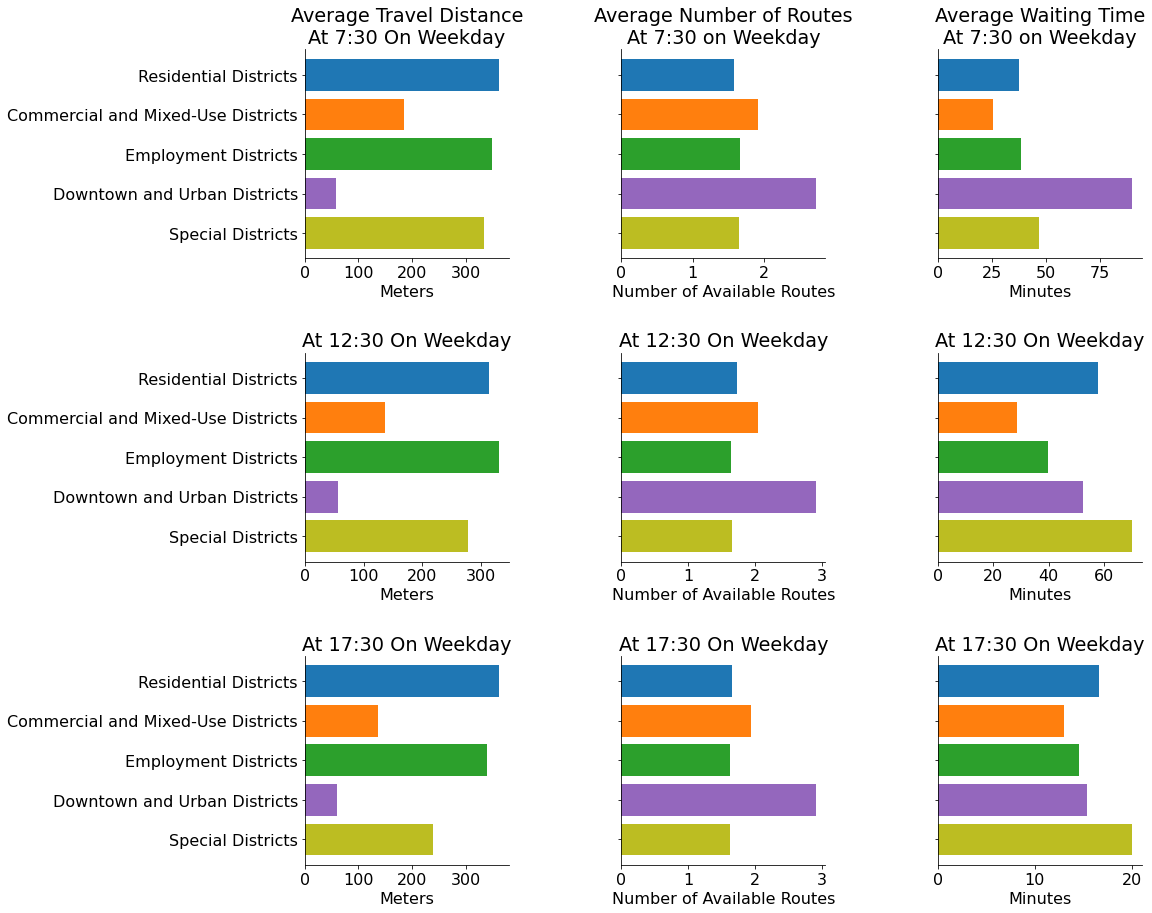

In [38]:
colors = ["tab:blue", "tab:orange", "tab:green", "tab:purple", "tab:olive"]
#####################  REPORT of 1116.md  #####################

#####################  wkd  #####################
fig, ((ax1, ax2, ax3),
      (ax4, ax5, ax6),
      (ax7, ax8, ax9)) = plt.subplots(ncols=3, nrows=3, figsize=(15, 15), sharey=True)
plt.rcParams["font.size"] = 16
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.subplots_adjust(hspace=0.45, wspace=0.55)


##################### ax1 - 3:  #####################
# ax1 7:30 weekday walking distance to bus stops
ax1.barh(ds, [d1_1["distance (in meters)"].mean(),
              d1_2["distance (in meters)"].mean(),
              d1_3["distance (in meters)"].mean(),
              d1_4["distance (in meters)"].mean(),
              d1_5["distance (in meters)"].mean()], align='center', color=colors, linewidth=3.5)
ax1.invert_yaxis()  # labels read top-to-bottom
ax1.set_title('Average Travel Distance\nAt 7:30 On Weekday')
ax1.set_xlabel('Meters')

# ax2 7:30 weekday number of available routes
ax2.barh(ds, [d1_1["num_available_routes"].mean(),
              d1_2["num_available_routes"].mean(),
              d1_3["num_available_routes"].mean(),
              d1_4["num_available_routes"].mean(),
              d1_5["num_available_routes"].mean()], align='center', color=colors, linewidth=3.5)
ax2.invert_yaxis()  # labels read top-to-bottom
ax2.set_title('Average Number of Routes\nAt 7:30 on Weekday')
ax2.set_xlabel('Number of Available Routes')

# ax3 7:30 weekday waiting time
ax3.barh(ds, [d1_1["minutes_wait"].dropna().mean(),
              d1_2["minutes_wait"].dropna().mean(),
              d1_3["minutes_wait"].dropna().mean(),
              d1_4["minutes_wait"].dropna().mean(),
              d1_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax3.invert_yaxis()  # labels read top-to-bottom
ax3.set_title('Average Waiting Time\nAt 7:30 on Weekday')
ax3.set_xlabel('Minutes')

##################### ax4 - 6:  #####################
# ax4 12:30 weekday walking distance to bus stops
ax4.barh(ds, [d2_1["distance (in meters)"].mean(),
              d2_2["distance (in meters)"].mean(),
              d2_3["distance (in meters)"].mean(),
              d2_4["distance (in meters)"].mean(),
              d2_5["distance (in meters)"].mean()], align='center', color=colors, linewidth=3.5)
ax4.invert_yaxis()  # labels read top-to-bottom
ax4.set_title('At 12:30 On Weekday')
ax4.set_xlabel('Meters')

# ax5 12:30 weekday number of available routes
ax5.barh(ds, [d2_1["num_available_routes"].mean(),
              d2_2["num_available_routes"].mean(),
              d2_3["num_available_routes"].mean(),
              d2_4["num_available_routes"].mean(),
              d2_5["num_available_routes"].mean()], align='center', color=colors, linewidth=3.5)
ax5.invert_yaxis()  # labels read top-to-bottom
ax5.set_title('At 12:30 On Weekday')
ax5.set_xlabel('Number of Available Routes')

# ax6 12:30 weekday waiting time
ax6.barh(ds, [d2_1["minutes_wait"].dropna().mean(),
              d2_2["minutes_wait"].dropna().mean(),
              d2_3["minutes_wait"].dropna().mean(),
              d2_4["minutes_wait"].dropna().mean(),
              d2_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax6.invert_yaxis()  # labels read top-to-bottom
ax6.set_title('At 12:30 On Weekday')
ax6.set_xlabel('Minutes')


##################### ax7 - 9:  #####################
# ax7 17:30 weekday walking distance to bus stops
ax7.barh(ds, [d1_1["distance (in meters)"].mean(),
              d2_2["distance (in meters)"].mean(),
              d3_3["distance (in meters)"].mean(),
              d4_4["distance (in meters)"].mean(),
              d5_5["distance (in meters)"].mean()], align='center', color=colors, linewidth=3.5)
ax7.invert_yaxis()  # labels read top-to-bottom
ax7.set_title('At 17:30 On Weekday')
ax7.set_xlabel('Meters')

# ax8 17:30 weekday number of available routes
ax8.barh(ds, [d3_1["num_available_routes"].mean(),
              d3_2["num_available_routes"].mean(),
              d3_3["num_available_routes"].mean(),
              d3_4["num_available_routes"].mean(),
              d3_5["num_available_routes"].mean()], align='center', color=colors, linewidth=3.5)
ax8.invert_yaxis()  # labels read top-to-bottom
ax8.set_title('At 17:30 On Weekday')
ax8.set_xlabel('Number of Available Routes')

# ax9 17:30 weekday waiting time
ax9.barh(ds, [d3_1["minutes_wait"].dropna().mean(),
              d3_2["minutes_wait"].dropna().mean(),
              d3_3["minutes_wait"].dropna().mean(),
              d3_4["minutes_wait"].dropna().mean(),
              d3_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax9.invert_yaxis()  # labels read top-to-bottom
ax9.set_title('At 17:30 On Weekday')
ax9.set_xlabel('Minutes')
plt.savefig("../report/11_16th/weekday_png", dpi=300, bbox_inches="tight")

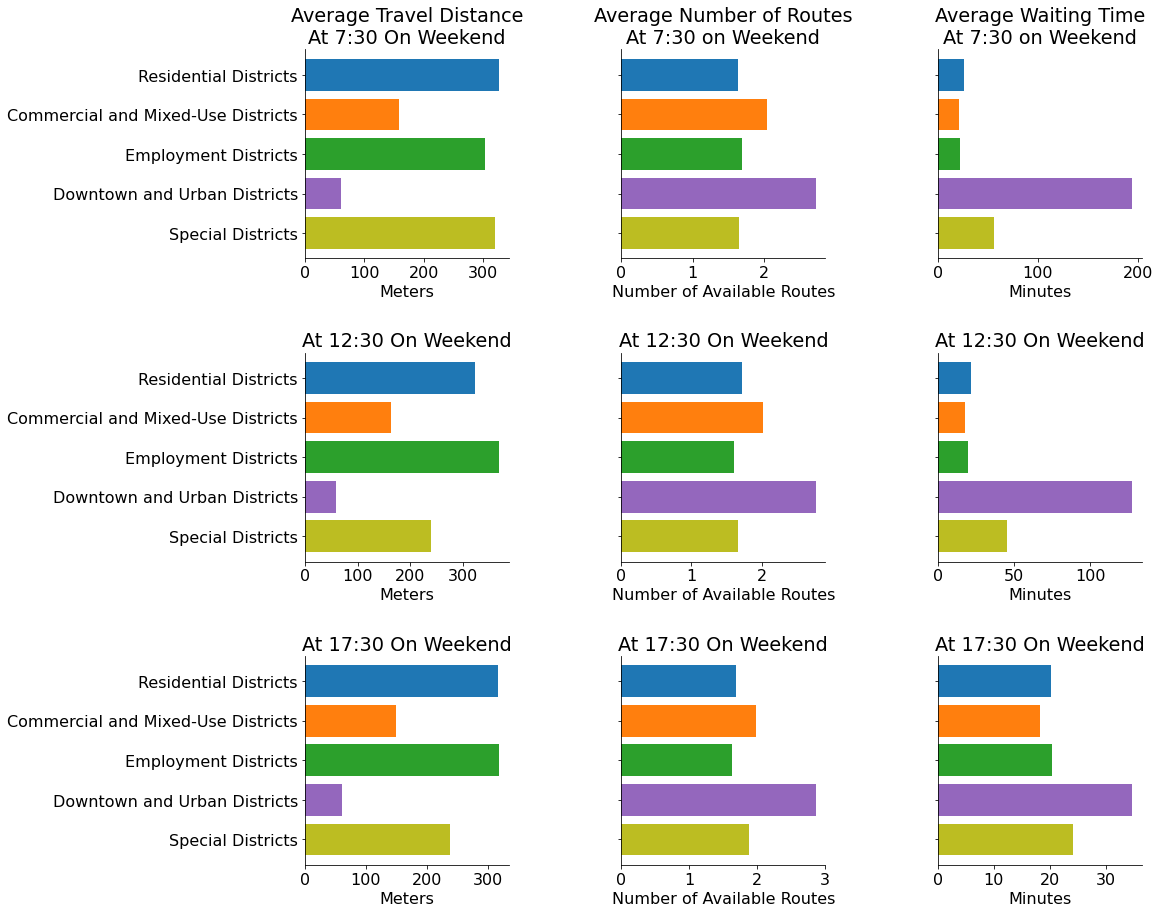

In [39]:
#####################  weekend  #####################
fig, ((ax1, ax2, ax3),
      (ax4, ax5, ax6),
      (ax7, ax8, ax9)) = plt.subplots(ncols=3, nrows=3, figsize=(15, 15), sharey=True)
plt.rcParams["font.size"] = 16
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.subplots_adjust(hspace=0.45, wspace=0.55)


##################### ax1 - 3:  #####################
# ax1 7:30 Weekend walking distance to bus stops
ax1.barh(ds, [d4_1["distance (in meters)"].mean(),
              d4_2["distance (in meters)"].mean(),
              d4_3["distance (in meters)"].mean(),
              d4_4["distance (in meters)"].mean(),
              d4_5["distance (in meters)"].mean()], align='center', color=colors, linewidth=3.5)
ax1.invert_yaxis()  # labels read top-to-bottom
ax1.set_title('Average Travel Distance\nAt 7:30 On Weekend')
ax1.set_xlabel('Meters')

# ax2 7:30 weekday number of available routes
ax2.barh(ds, [d4_1["num_available_routes"].mean(),
              d4_2["num_available_routes"].mean(),
              d4_3["num_available_routes"].mean(),
              d4_4["num_available_routes"].mean(),
              d4_5["num_available_routes"].mean()], align='center', color=colors, linewidth=3.5)
ax2.invert_yaxis()  # labels read top-to-bottom
ax2.set_title('Average Number of Routes\nAt 7:30 on Weekend')
ax2.set_xlabel('Number of Available Routes')

# ax3 7:30 Weekend waiting time
ax3.barh(ds, [d4_1["minutes_wait"].dropna().mean(),
              d4_2["minutes_wait"].dropna().mean(),
              d4_3["minutes_wait"].dropna().mean(),
              d4_4["minutes_wait"].dropna().mean(),
              d4_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax3.invert_yaxis()  # labels read top-to-bottom
ax3.set_title('Average Waiting Time\nAt 7:30 on Weekend')
ax3.set_xlabel('Minutes')

##################### ax4 - 6:  #####################
# ax4 12:30 Weekend walking distance to bus stops
ax4.barh(ds, [d5_1["distance (in meters)"].mean(),
              d5_2["distance (in meters)"].mean(),
              d5_3["distance (in meters)"].mean(),
              d5_4["distance (in meters)"].mean(),
              d5_5["distance (in meters)"].mean()], align='center', color=colors, linewidth=3.5)
ax4.invert_yaxis()  # labels read top-to-bottom
ax4.set_title('At 12:30 On Weekend')
ax4.set_xlabel('Meters')

# ax5 12:30 Weekend number of available routes
ax5.barh(ds, [d5_1["num_available_routes"].mean(),
              d5_2["num_available_routes"].mean(),
              d5_3["num_available_routes"].mean(),
              d5_4["num_available_routes"].mean(),
              d5_5["num_available_routes"].mean()], align='center', color=colors, linewidth=3.5)
ax5.invert_yaxis()  # labels read top-to-bottom
ax5.set_title('At 12:30 On Weekend')
ax5.set_xlabel('Number of Available Routes')

# ax6 12:30 Weekend waiting time
ax6.barh(ds, [d5_1["minutes_wait"].dropna().mean(),
              d5_2["minutes_wait"].dropna().mean(),
              d5_3["minutes_wait"].dropna().mean(),
              d5_4["minutes_wait"].dropna().mean(),
              d5_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax6.invert_yaxis()  # labels read top-to-bottom
ax6.set_title('At 12:30 On Weekend')
ax6.set_xlabel('Minutes')


##################### ax7 - 9:  #####################
# ax7 17:30 Weekend walking distance to bus stops
ax7.barh(ds, [d6_1["distance (in meters)"].mean(),
              d6_2["distance (in meters)"].mean(),
              d6_3["distance (in meters)"].mean(),
              d6_4["distance (in meters)"].mean(),
              d6_5["distance (in meters)"].mean()], align='center', color=colors, linewidth=3.5)
ax7.invert_yaxis()  # labels read top-to-bottom
ax7.set_title('At 17:30 On Weekend')
ax7.set_xlabel('Meters')

# ax8 17:30 Weekend number of available routes
ax8.barh(ds, [d6_1["num_available_routes"].mean(),
              d6_2["num_available_routes"].mean(),
              d6_3["num_available_routes"].mean(),
              d6_4["num_available_routes"].mean(),
              d6_5["num_available_routes"].mean()], align='center', color=colors, linewidth=3.5)
ax8.invert_yaxis()  # labels read top-to-bottom
ax8.set_title('At 17:30 On Weekend')
ax8.set_xlabel('Number of Available Routes')

# ax9 17:30 Weekend waiting time
ax9.barh(ds, [d6_1["minutes_wait"].dropna().mean(),
              d6_2["minutes_wait"].dropna().mean(),
              d6_3["minutes_wait"].dropna().mean(),
              d6_4["minutes_wait"].dropna().mean(),
              d6_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax9.invert_yaxis()  # labels read top-to-bottom
ax9.set_title('At 17:30 On Weekend')
ax9.set_xlabel('Minutes')
plt.savefig("../report/11_16th/weekend_png", dpi=300, bbox_inches="tight")


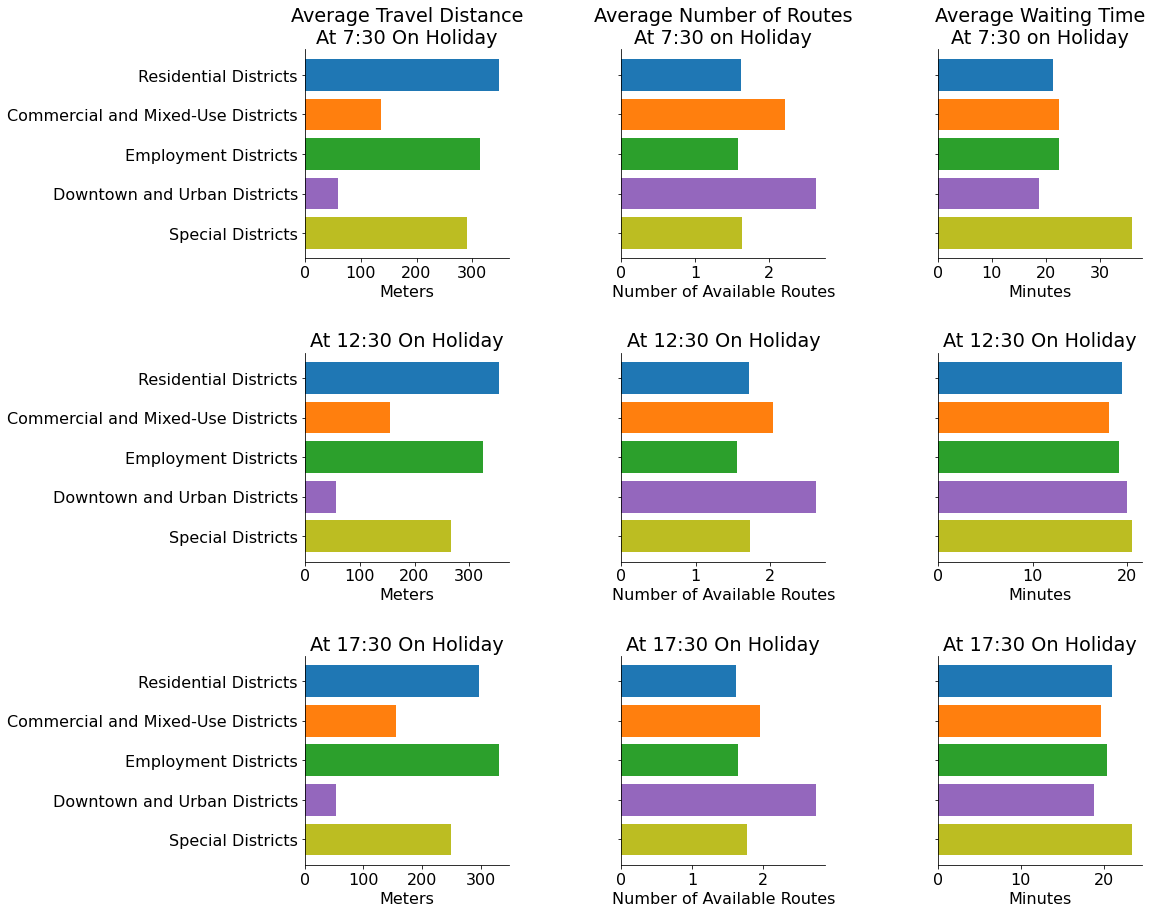

In [40]:
#####################  hol  #####################
fig, ((ax1, ax2, ax3),
      (ax4, ax5, ax6),
      (ax7, ax8, ax9)) = plt.subplots(ncols=3, nrows=3, figsize=(15, 15), sharey=True)
plt.rcParams["font.size"] = 16
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.subplots_adjust(hspace=0.45, wspace=0.55)


##################### ax1 - 3:  #####################
# ax1 7:30 Holiday walking distance to bus stops
ax1.barh(ds, [d7_1["distance (in meters)"].mean(),
              d7_2["distance (in meters)"].mean(),
              d7_3["distance (in meters)"].mean(),
              d7_4["distance (in meters)"].mean(),
              d7_5["distance (in meters)"].mean()], align='center', color=colors, linewidth=3.5)
ax1.invert_yaxis()  # labels read top-to-bottom
ax1.set_title('Average Travel Distance\nAt 7:30 On Holiday')
ax1.set_xlabel('Meters')

# ax2 7:30 Holiday number of available routes
ax2.barh(ds, [d7_1["num_available_routes"].mean(),
              d7_2["num_available_routes"].mean(),
              d7_3["num_available_routes"].mean(),
              d7_4["num_available_routes"].mean(),
              d7_5["num_available_routes"].mean()], align='center', color=colors, linewidth=3.5)
ax2.invert_yaxis()  # labels read top-to-bottom
ax2.set_title('Average Number of Routes\nAt 7:30 on Holiday')
ax2.set_xlabel('Number of Available Routes')

# ax3 7:30 Holiday waiting time
ax3.barh(ds, [d7_1["minutes_wait"].dropna().mean(),
              d7_2["minutes_wait"].dropna().mean(),
              d7_3["minutes_wait"].dropna().mean(),
              d7_4["minutes_wait"].dropna().mean(),
              d7_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax3.invert_yaxis()  # labels read top-to-bottom
ax3.set_title('Average Waiting Time\nAt 7:30 on Holiday')
ax3.set_xlabel('Minutes')

##################### ax4 - 6:  #####################
# ax4 12:30 Holiday walking distance to bus stops
ax4.barh(ds, [d8_1["distance (in meters)"].mean(),
              d8_2["distance (in meters)"].mean(),
              d8_3["distance (in meters)"].mean(),
              d8_4["distance (in meters)"].mean(),
              d8_5["distance (in meters)"].mean()], align='center', color=colors, linewidth=3.5)
ax4.invert_yaxis()  # labels read top-to-bottom
ax4.set_title('At 12:30 On Holiday')
ax4.set_xlabel('Meters')

# ax5 12:30 Holiday number of available routes
ax5.barh(ds, [d8_1["num_available_routes"].mean(),
              d8_2["num_available_routes"].mean(),
              d8_3["num_available_routes"].mean(),
              d8_4["num_available_routes"].mean(),
              d8_5["num_available_routes"].mean()], align='center', color=colors, linewidth=3.5)
ax5.invert_yaxis()  # labels read top-to-bottom
ax5.set_title('At 12:30 On Holiday')
ax5.set_xlabel('Number of Available Routes')

# ax6 12:30 Holiday waiting time
ax6.barh(ds, [d8_1["minutes_wait"].dropna().mean(),
              d8_2["minutes_wait"].dropna().mean(),
              d8_3["minutes_wait"].dropna().mean(),
              d8_4["minutes_wait"].dropna().mean(),
              d8_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax6.invert_yaxis()  # labels read top-to-bottom
ax6.set_title('At 12:30 On Holiday')
ax6.set_xlabel('Minutes')


##################### ax7 - 9:  #####################
# ax7 17:30 Holiday walking distance to bus stops
ax7.barh(ds, [d9_1["distance (in meters)"].mean(),
              d9_2["distance (in meters)"].mean(),
              d9_3["distance (in meters)"].mean(),
              d9_4["distance (in meters)"].mean(),
              d9_5["distance (in meters)"].mean()], align='center', color=colors, linewidth=3.5)
ax7.invert_yaxis()  # labels read top-to-bottom
ax7.set_title('At 17:30 On Holiday')
ax7.set_xlabel('Meters')

# ax8 17:30 Holiday number of available routes
ax8.barh(ds, [d9_1["num_available_routes"].mean(),
              d9_2["num_available_routes"].mean(),
              d9_3["num_available_routes"].mean(),
              d9_4["num_available_routes"].mean(),
              d9_5["num_available_routes"].mean()], align='center', color=colors, linewidth=3.5)
ax8.invert_yaxis()  # labels read top-to-bottom
ax8.set_title('At 17:30 On Holiday')
ax8.set_xlabel('Number of Available Routes')

# ax9 17:30 Holiday waiting time
ax9.barh(ds, [d9_1["minutes_wait"].dropna().mean(),
              d9_2["minutes_wait"].dropna().mean(),
              d9_3["minutes_wait"].dropna().mean(),
              d9_4["minutes_wait"].dropna().mean(),
              d9_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax9.invert_yaxis()  # labels read top-to-bottom
ax9.set_title('At 17:30 On Holiday')
ax9.set_xlabel('Minutes')
plt.savefig("../report/11_16th/holiday_png", dpi=300, bbox_inches="tight")




In [48]:
# li = []
# li.extend(zone_category["Overlay Districts"])
# li.extend(zone_category["Historic Districts"])
# zones[zones["ZONING_COD"].isin(li)]

colors = ["tab:blue", "tab:orange", "tab:green", "tab:purple", "tab:olive"]
zones.head()

OBJECTID ZONING_COD ZON_ANNO  PD_ID ZON_PREFIX  \
0    385679         IL     None    0.0       None   
1    385680         CN     None    0.0       None   
2    385681          A     None    0.0       None   
3    385682         PD     None    0.0       None   
4    385683      SR-C3     None    0.0       None   

                                          Zoning_Doc  \
0  https://library.municode.com/wi/madison/codes/...   
1  https://library.municode.com/wi/madison/codes/...   
2  https://library.municode.com/wi/madison/codes/...   
3  https://library.municode.com/wi/madison/codes/...   
4  https://library.municode.com/wi/madison/codes/...   

                                          Zoning_Dis     ShapeSTAre  \
0  http://www.cityofmadison.com/assessor/document...  382314.168060   
1  http://www.cityofmadison.com/assessor/document...  325736.029938   
2  http://www.cityofmadison.com/assessor/document...  148709.001678   
3  http://www.cityofmadison.com/assessor/document...  206218.462555   
4  http://www.cityofmadison.com/assessor/document...  614856.434540   

    ShapeSTLen                                           geometry  
0  2902.051331  POLYGON ((-89.40746 43.04228, -89.40742 43.042...  
1  3474.332182  POLYGON ((-89.48547 43.08493, -89.48501 43.084...  
2  3290.156442  POLYGON ((-89.27990 43.11615, -89.27995 43.116...  
3  1859.121924  POLYGON ((-89.53548 43.06887, -89.53554 43.068...  
4  6049.492059  POLYGON ((-89.48808 43.06345, -89.48871 43.063...

Residential Districts
Commercial and Mixed-Use Districts
Employment Districts
Downtown and Urban Districts
Special Districts
Overlay Districts
Historic Districts


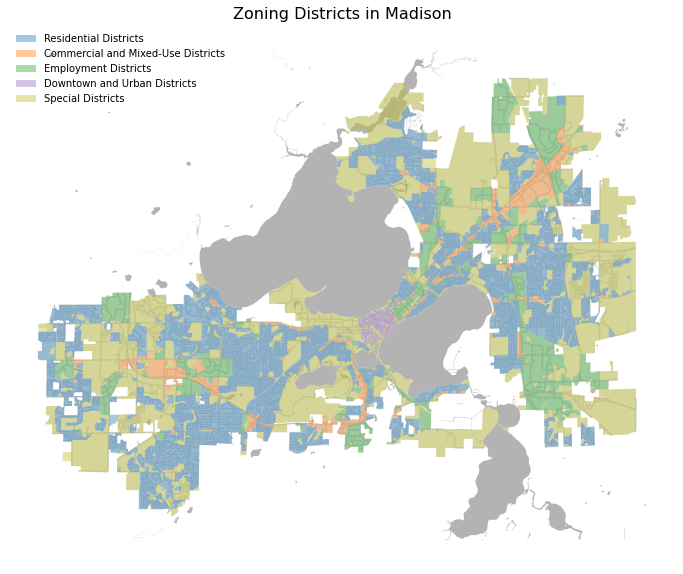

In [74]:

fig, ax = plt.subplots(figsize=(12, 10))
city.plot(ax=ax, color="0.9")
water.plot(ax=ax, color="0.7")
street.plot(ax=ax, color="0.8")

cnt = 0
handles = []
for key, val in zone_category.items():
    print(key)
    if len(zones[zones["ZONING_COD"].isin(zone_category[key])]) == 0:
        continue
    else:
        temp = zones[zones["ZONING_COD"].isin(zone_category[key])]
        c = colors[cnt]
        cnt += 1

        temp.plot(ax=ax, color=c, zorder=2, alpha=0.4, label=key, legend=True)

p0 = Patch(facecolor=colors[0], label=list(zone_category.keys())[0], alpha=0.4)
p1 = Patch(facecolor=colors[1], label=list(zone_category.keys())[1], alpha=0.4)
p2 = Patch(facecolor=colors[2], label=list(zone_category.keys())[2], alpha=0.4)
p3 = Patch(facecolor=colors[3], label=list(zone_category.keys())[3], alpha=0.4)
p4 = Patch(facecolor=colors[4], label=list(zone_category.keys())[4], alpha=0.4)

ax.set_title("Zoning Districts in Madison", size=16)
patches = [p0, p1, p2, p3, p4]
ax.legend(handles=patches, loc='upper left', frameon=False)
ax.set_axis_off()
plt.savefig("../report/11_16th/intro_png", dpi=300, bbox_inches="tight")

